In [1]:
# !pip install Orange3
from utils.base_helpers import download_artifact
import pandas as pd
import wandb
import plotly.express as px
import warnings; warnings.filterwarnings("ignore")
from itertools import product
from plotly.subplots import make_subplots
import plotly.graph_objects as go
wandb.init(project="keras")

wandb: Currently logged in as: merts (use `wandb login --relogin` to force relogin)
2022-06-05 10:48:56.544223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-05 10:48:56.544243: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# HelperFunc

In [2]:
from utils.base_helpers import DataReader

ratios = [0.56095, 0.082, 0.082, 0.08288, 0.0838, 0.0838]
train_ratio_, valid_ratio_, test_ratio_ = ratios[:3]
print("Starting")
data = DataReader(number_of_plants=90)
data.process(train_ratio=train_ratio_, valid_ratio=valid_ratio_, test_ratio=test_ratio_, scaler=None, expand=False)

Starting
Train start and end dates:	 2019-01-26 03:00:00 	 2020-10-02 22:00:00
Validation start and end dates:	 2020-10-02 23:00:00 	 2020-12-31 23:00:00
Test start and end dates:	 2021-01-01 00:00:00 	 2021-03-31 23:00:00


In [3]:
plant_prods = data.raw_df.groupby("rt_plant_id").production.mean().reset_index()
plant_prods["category"] = "Low"
plant_prods.loc[plant_prods["production"] > data.raw_df.groupby("rt_plant_id").production.mean().quantile(0.4), "category"] = "Mid"
plant_prods.loc[plant_prods["production"] > data.raw_df.groupby("rt_plant_id").production.mean().quantile(0.8), "category"] = "High"
plant_dict = dict(zip(plant_prods.rt_plant_id, plant_prods.category))

months = ['Jan', 'Feb', 'Mar', 'Apr', "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_dict = {k:v for k, v in zip(range(1,13), months)}

In [4]:
scalers = {}
from sklearn.preprocessing import MinMaxScaler as scaler_

for plant_id in data.train_df.rt_plant_id.unique():
    scalers[plant_id] = scaler_()
    scalers[plant_id] = scalers[plant_id].fit(data.train_df.loc[data.train_df["rt_plant_id"] == plant_id][["production"]])

In [5]:
import numpy as np

class Metrics:
    def __init__(self, df):
        df_ = df.copy()
        self.df = self.inverse_transform(df_)
        self.wmape_func = lambda x: self.calculate_wmape(x["predictions"], x["actuals"])
        self.bias_func = lambda x: self.calculate_bias(x["predictions"], x["actuals"])
    
    @staticmethod
    def inverse_transform(predictions):
        for plant_id in data.plants:
            predictions.loc[predictions["rt_plant_id"] == plant_id, ["actuals", "predictions"]] = scalers[plant_id].inverse_transform(predictions.loc[predictions["rt_plant_id"] == plant_id, ["actuals", "predictions"]])
        predictions[["actuals", "predictions"]] = predictions[["actuals", "predictions"]].round(2)
        return predictions
        
    def calculate(self):
        self.df["hour"] = self.df["forecast_dt"].dt.hour
        # self.df["date"] = self.df["forecast_dt"].dt.date
        # self.df["week"] = self.df["forecast_dt"].dt.isocalendar().week
        self.df["month"] = self.df["forecast_dt"].dt.month
        self.df["category"] = self.df.rt_plant_id.map(plant_dict)
        
        self.wmape = self.wmape_func(self.df)
        self.bias = self.bias_func(self.df)
        
        # self.dwmape = self.df.groupby("date").apply(self.wmape_func)
        # self.dbias = self.df.groupby("date").apply(self.bias_func)
        # self.dwmape_median, self.dwmape_std = self.dwmape.median(), self.dwmape.std()
        # self.dbias_median, self.dbias_std = self.dbias.median(), self.dbias.std()

        self.mwmape = self.df.groupby("month").apply(self.wmape_func)
        self.mbias = self.df.groupby("month").apply(self.bias_func)
        self.mwmape_median, self.mwmape_std = self.mwmape.median(), self.mwmape.std()
        self.mbias_median, self.mbias_std = self.mbias.median(), self.mbias.std()

        self.pwmape = self.df.groupby("rt_plant_id").apply(self.wmape_func)
        self.pbias = self.df.groupby("rt_plant_id").apply(self.bias_func)
        self.pwmape_median, self.pwmape_std = self.pwmape.median(), self.pwmape.std()
        self.pbias_median, self.pbias_std = self.pbias.median(), self.pbias.std()

        self.cwmape = self.df.groupby("category").apply(self.wmape_func)
        self.cbias = self.df.groupby("category").apply(self.bias_func)
        self.cwmape_median, self.cwmape_std = self.cwmape.median(), self.cwmape.std()
        self.cbias_median, self.cbias_std = self.cbias.median(), self.cbias.std()

        # self.hwmape = self.df.groupby("hour").apply(self.wmape_func)
        # self.hbias = self.df.groupby("hour").apply(self.bias_func)
        # self.hwmape_median, self.hwmape_std = self.hwmape.median(), self.hwmape.std()
        # self.hbias_median, self.hbias_std = self.hbias.median(), self.hbias.std()

    def to_df(self, model, how="overall"):
        assert how in ["overall", "month", "rt_plant_id", "category"]
        cols = ["wmape_median", "wmape_std", "bias_median", "bias_std"]
        map_dict = {
            "overall": ["wmape", "bias"],
            # "date": ["d"+col for col in cols],
            # "week": ["w"+col for col in cols],
            "rt_plant_id": ["p"+col for col in cols],
            # "hour": ["h"+col for col in cols],
            "category": ["c"+col for col in cols],
            "month": ["m"+col for col in cols],
        }
        out_df = pd.DataFrame({k:[v] for k,v in self.__dict__.items() if k in map_dict[how]})
        out_df["model"] = model
        return out_df
            
    @staticmethod
    def calculate_wmape(preds, actuals):
        return np.sum(np.abs(preds-actuals)) / np.sum(np.abs(actuals))

    @staticmethod
    def calculate_bias(preds, actuals):
        return np.sum(preds-actuals) / np.sum(actuals)
    
    def plot_heatmap(self, which="hour", transpose=True, range_color=[0.2,0.7], linear=False):
        assert which in ["hour", "rt_plant_id", "category"]
        plot_df = pd.pivot_table(self.df.groupby(["month", which]).apply(self.wmape_func).reset_index(), index=[which], columns=["month"], values=0)
        plot_df.columns = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
        plot_df.index = plot_df.index.astype(str)
        if which == "rt_plant_id":
            plot_df = plot_df.loc[plot_df.mean(axis=1).sort_values().index]
        y = "Hour of Day" if which == "hour" else "Production Capacity" if which == "category" else "Plant ID"
        x = "Month"
        if transpose:
            plot_df = plot_df.T
            x, y = y, x
        fig = px.imshow(plot_df, labels=dict(x=x, y=y, color="WMAPE"), aspect="auto",
                        range_color=range_color, color_continuous_scale=px.colors.diverging.RdYlBu[::-1])
        if linear:
            fig.update_xaxes(side="bottom", tickangle=60, tickmode="linear")
            fig.update_yaxes(tickmode="linear")
        else:
            fig.update_xaxes(side="bottom", tickangle=60)
        
        fig.update_layout(autosize=False, width=500, height=500)
        # fig.show()
        self.fig = fig
    

class Mert:
    def __init__(self, ids):
        self.ids = ids
        self.data = []
        
    def read(self):
        for wandb_id in self.ids:
            self.data.append(self.artifacts(wandb_id))
        self.data = pd.concat([i["predictions"] for i in self.data])
        
    def generate(self, name):
        self.read()
        self.metrics = Metrics(self.data)
        self.metrics.calculate()
        overall = self.metrics.to_df(name, "overall")
        # week = self.metrics.to_df(name, "week")
        # date = self.metrics.to_df(name, "date")
        # hour = self.metrics.to_df(name, "hour")
        category = self.metrics.to_df(name, "category")
        month = self.metrics.to_df(name, "month")
        plant = self.metrics.to_df(name, "rt_plant_id")
        return overall, month, category, plant
    
    @staticmethod
    def artifacts(wandb_id):
        predictions = download_artifact(f'merts/keras/run-{wandb_id}-test_predictions:v0')
        return {"predictions": predictions}
    
    def plot_heatmap(self, **kwargs):
        self.metrics.plot_heatmap(**kwargs)
        self.fig = self.metrics.fig

# Plotting

In [6]:
COLORS = px.colors.diverging.RdYlBu[::-1]
# COLORS = px.colors.sequential.Greys[1:] # dropping pure white

## MLP

In [7]:
# 60
# mlp = Mert(["1wo20kk5", "1rdg2wjz", "olozkfwl", "lgzwtmz0"])
# mlp2 = Mert(["3plm4e3z", "3dmte7d9", "1xzjhuym", "2qz32dz2"])

# 48
# mlp = Mert(["2wqd0a9h", "98w0pq58", "23ugpyx4", "3c9xs9yd"])
# mlp2 = Mert(["18m998io", "28y97tv2", "1b201aa1", "3vzxj048"])

mlp = Mert(["1wo20kk5", "1rdg2wjz", "olozkfwl", "lgzwtmz0"])
mlp_overall, mlp_month, mlp_category, mlp_plant = mlp.generate("mlp")

mlp2 = Mert(["18m998io", "28y97tv2", "1b201aa1", "3vzxj048"])
mlp2_overall, mlp2_month, mlp2_category, mlp2_plant = mlp2.generate("mlp2")

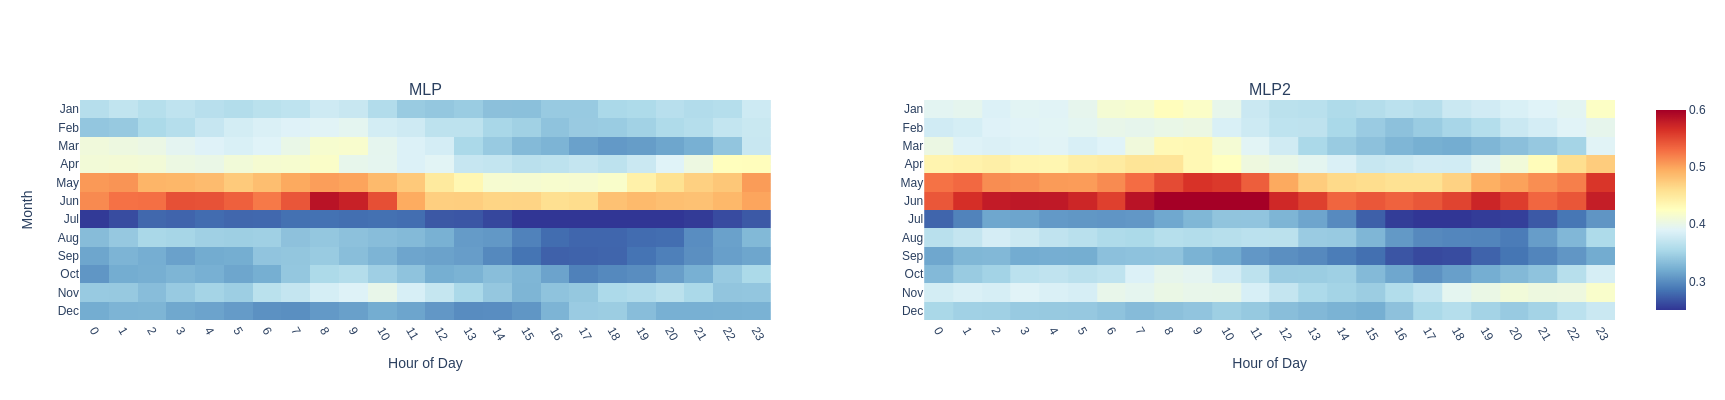

In [8]:
mlp.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])
mlp2.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])

fig = make_subplots(rows=1, cols=2, subplot_titles=["MLP", "MLP2"])
fig.add_trace(mlp.fig.data[0], row=1, col=1)
fig.add_trace(mlp2.fig.data[0], row=1, col=2)
    
fig.update_layout(coloraxis_autocolorscale=False, coloraxis_colorscale=COLORS)
fig.update_layout(autosize=False, width=800, height=400, coloraxis=dict(cmax=0.6, cmin=0.25))
fig.update_xaxes(side="bottom", tickmode="linear", tickangle=60)
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])

fig['layout']['xaxis']['title']='Hour of Day'
fig['layout']['xaxis2']['title']='Hour of Day'
fig['layout']['yaxis']['title']='Month'

fig.show()

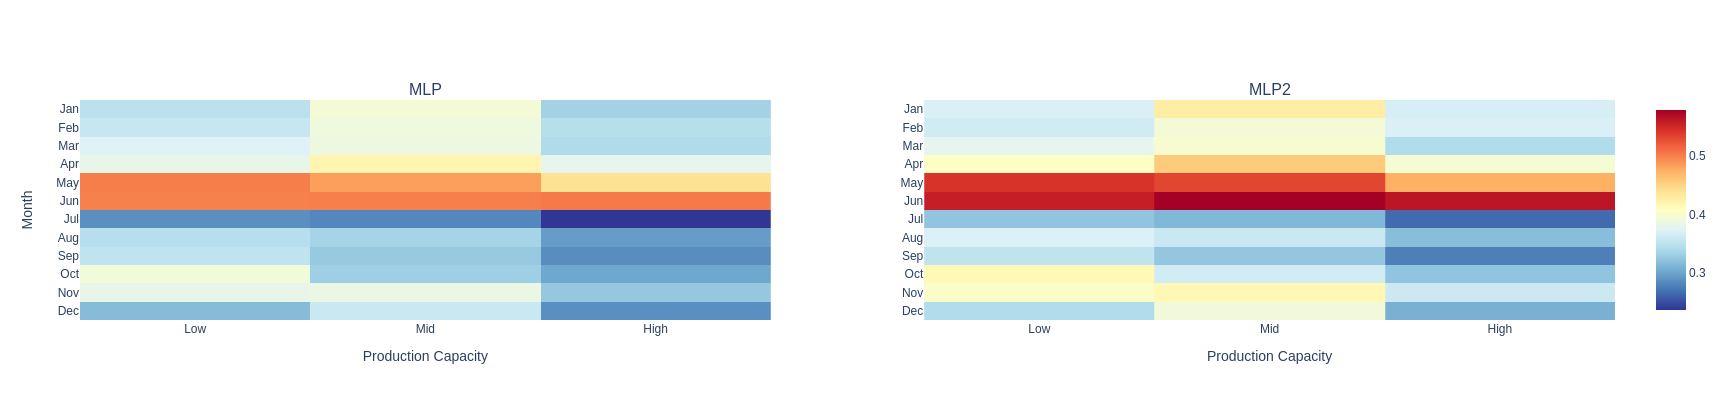

In [9]:
mlp.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
mlp2.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])

fig = make_subplots(rows=1, cols=2, subplot_titles=["MLP", "MLP2"])
fig.add_trace(mlp.fig.data[0], row=1, col=1)
fig.add_trace(mlp2.fig.data[0], row=1, col=2)
    
fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=800, height=400, coloraxis_colorscale=COLORS)
fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])

fig['layout']['xaxis']['title']='Production Capacity'
fig['layout']['xaxis2']['title']='Production Capacity'
fig['layout']['yaxis']['title']='Month'


fig.show()

In [10]:
mlp_overall

wmape      bias model
0  0.349027 -0.034812   mlp

In [11]:
mlp2_overall

wmape      bias model
0  0.373116 -0.034957  mlp2

In [12]:
cols = ["wmape_median", "wmape_std", "bias_median", "bias_std", "how"]
mlp2_month.columns = cols
mlp2_month["how"] = "Monthly"
mlp2_plant.columns = cols
mlp2_plant["how"] = "Plant"
print(pd.concat([mlp2_month, mlp2_plant]).to_latex())

\begin{tabular}{lrrrrl}
\toprule
{} &  wmape\_median &  wmape\_std &  bias\_median &  bias\_std &      how \\
\midrule
0 &      0.373842 &   0.079965 &    -0.036752 &  0.079448 &  Monthly \\
0 &      0.375717 &   0.063198 &    -0.038514 &  0.102569 &    Plant \\
\bottomrule
\end{tabular}



In [13]:
cols = ["wmape_median", "wmape_std", "bias_median", "bias_std", "how"]
mlp_month.columns = cols
mlp_month["how"] = "Monthly"
mlp_plant.columns = cols
mlp_plant["how"] = "Plant"
print(pd.concat([mlp_month, mlp_plant]).to_latex())

\begin{tabular}{lrrrrl}
\toprule
{} &  wmape\_median &  wmape\_std &  bias\_median &  bias\_std &      how \\
\midrule
0 &      0.356699 &   0.067536 &    -0.027528 &  0.039392 &  Monthly \\
0 &      0.347401 &   0.054253 &    -0.043693 &  0.073539 &    Plant \\
\bottomrule
\end{tabular}



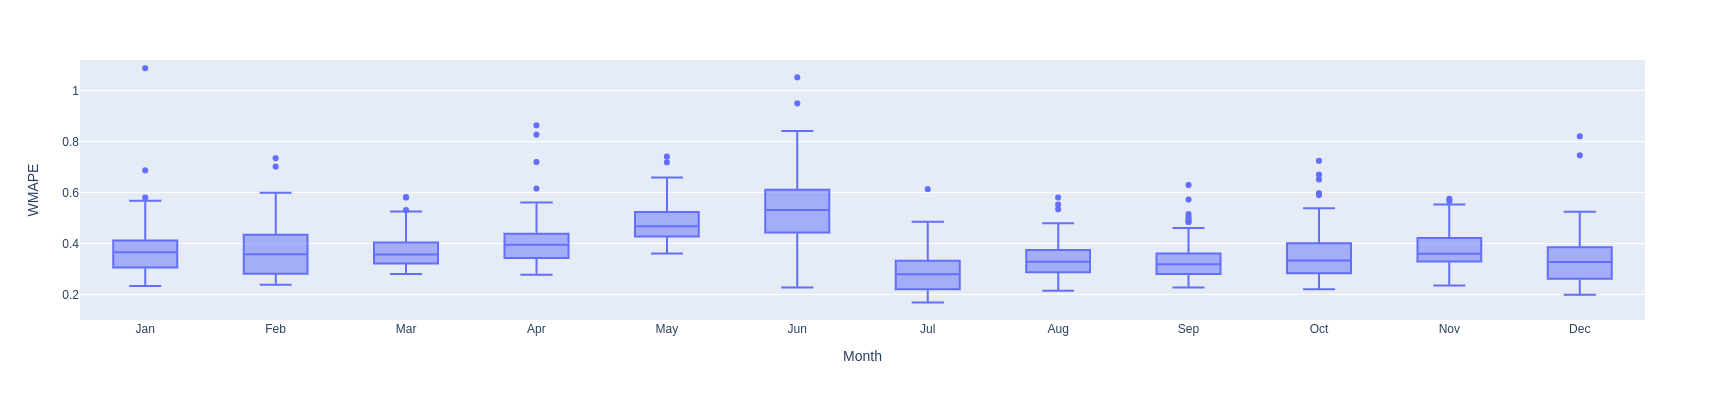

In [14]:
wmape_ = mlp.metrics.df.groupby(["rt_plant_id", "month"]).apply(lambda x: Metrics.calculate_wmape(x["predictions"], x["actuals"]))
wmape_ = wmape_.reset_index().rename(columns={0: "WMAPE", "month":"Month"})
wmape_["Month"] = wmape_["Month"].map(month_dict)
fig = px.box(wmape_, x="Month", y="WMAPE")
# fig = px.violin(wmape_, x="month", y="wmape")
fig.update_xaxes(categoryorder='array', categoryarray=months)
fig.update_layout(yaxis_range=[0.1,1.12], autosize=False, width=1200, height=400)
fig.show()

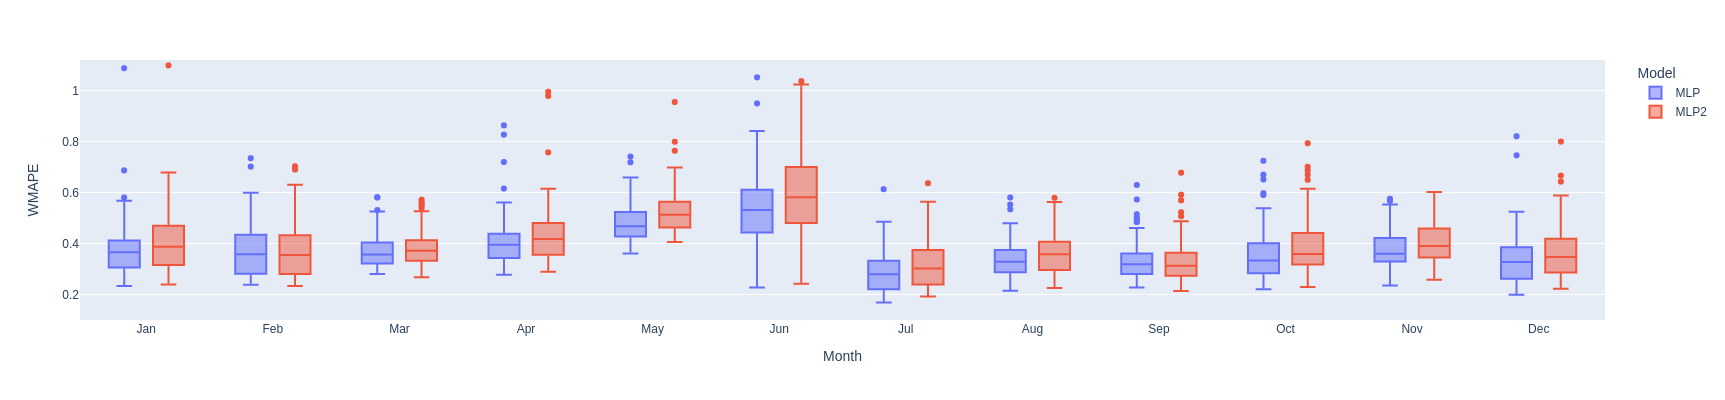

In [15]:
wmape_mlp = mlp.metrics.df.groupby(["rt_plant_id", "month"]).apply(lambda x: Metrics.calculate_wmape(x["predictions"], x["actuals"]))
wmape_mlp2 = mlp2.metrics.df.groupby(["rt_plant_id", "month"]).apply(lambda x: Metrics.calculate_wmape(x["predictions"], x["actuals"]))
temp = pd.concat([wmape_mlp, wmape_mlp2], axis=1)
temp.columns = ["MLP", "MLP2"]
temp = pd.melt(temp, var_name="metric", ignore_index=False).reset_index()
temp["month"] = temp["month"].map(month_dict)
fig = px.box(temp, x="month", y="value", color="metric", labels=dict(month="Month", value="WMAPE", metric="Model"))
fig.update_xaxes(tickmode="linear")
fig.update_layout(yaxis_range=[0.1,1.12], autosize=False, width=1200, height=400)
fig.show()

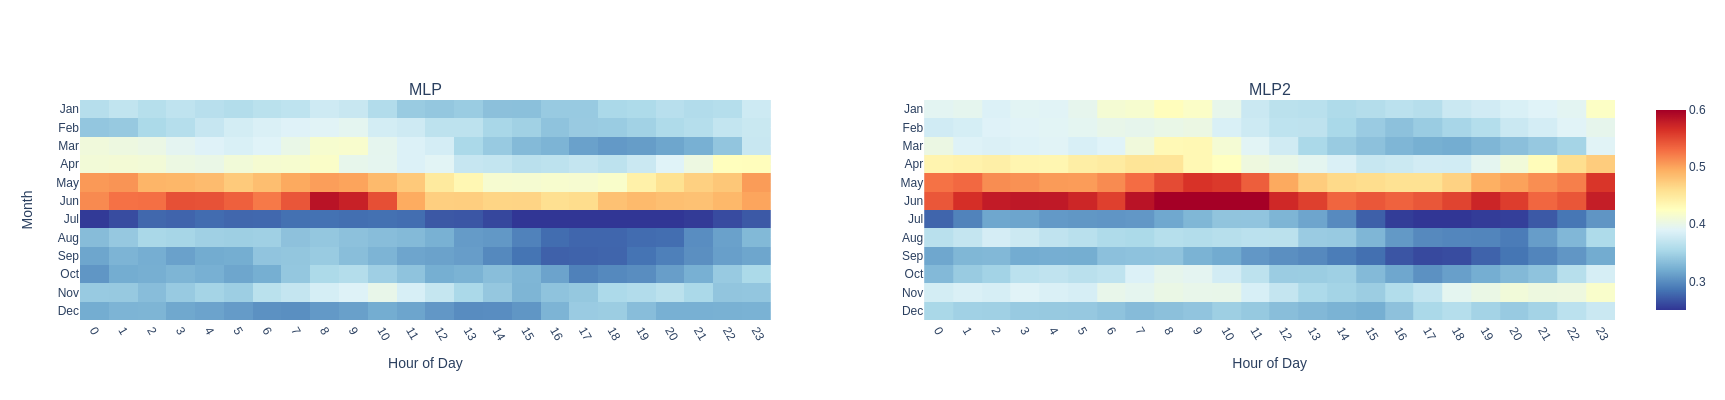

In [21]:
mlp.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])
mlp2.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])

fig = make_subplots(rows=1, cols=2, subplot_titles=["MLP", "MLP2"])
fig.add_trace(mlp.fig.data[0], row=1, col=1)
fig.add_trace(mlp2.fig.data[0], row=1, col=2)
    
fig.update_layout(coloraxis_autocolorscale=False, coloraxis_colorscale=COLORS)
fig.update_layout(autosize=False, width=800, height=400, coloraxis=dict(cmax=0.6, cmin=0.25))
fig.update_xaxes(side="bottom", tickmode="linear", tickangle=60)
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])

fig['layout']['xaxis']['title']='Hour of Day'
fig['layout']['xaxis2']['title']='Hour of Day'
fig['layout']['yaxis']['title']='Month'

fig.show()

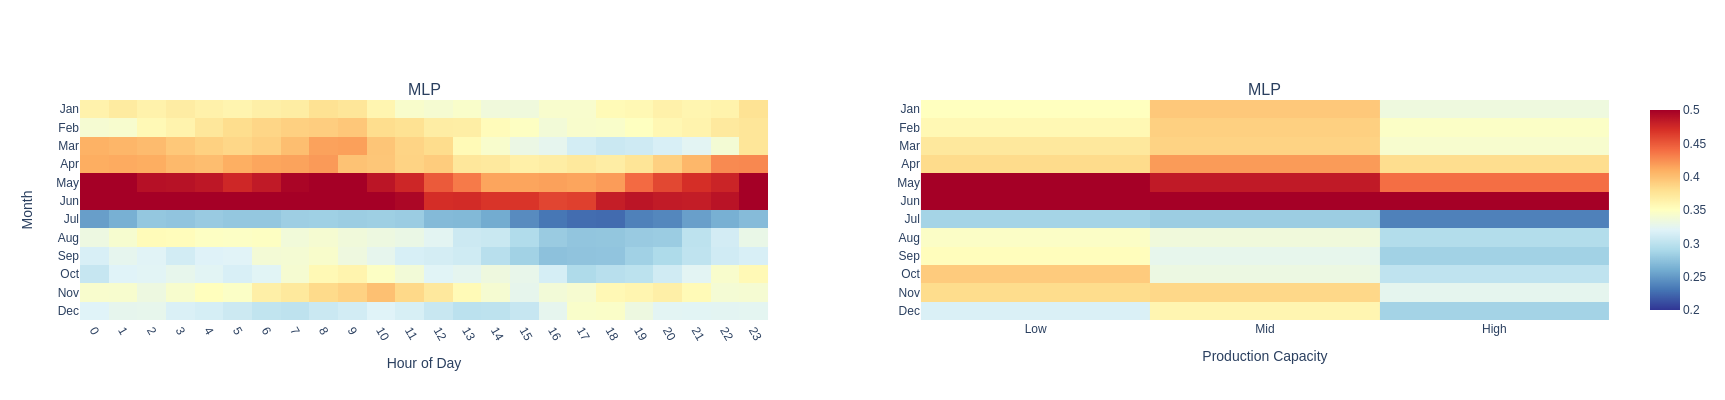

In [39]:
name = "mlp"
model = eval(name)
name = name.upper()

model.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])
data1 = model.fig.data[0]
model.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
data2= model.fig.data[0]

fig = make_subplots(rows=1, cols=2, subplot_titles=[name, name])
fig.add_trace(data1, row=1, col=1)
fig.add_trace(data2, row=1, col=2)

fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=800, height=400, coloraxis_colorscale=COLORS)
fig.update_layout(xaxis=dict(side="bottom", tickmode="linear", tickangle=60), xaxis2=dict(categoryorder='array', categoryarray=["Low", "Mid", "High"]))
# fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])
fig.update_layout(coloraxis=dict(cmax=0.5, cmin=0.2))

fig['layout']['xaxis']['title']='Hour of Day'
fig['layout']['xaxis2']['title']='Production Capacity'
fig['layout']['yaxis']['title']='Month'

fig.show()

## CNN

In [16]:
cnn = Mert(["2pw2oafo", "2ni8q5zy", "eix3jddl", "g55nqmkk"])
cnn_overall, cnn_month, cnn_category, cnn_plant = cnn.generate("cnn")
cnn_overall

wmape      bias model
0  0.302746 -0.050161   cnn

In [37]:
# cnn.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])

# cnn.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.5]); cnn.fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])

# cnn.fig.show()

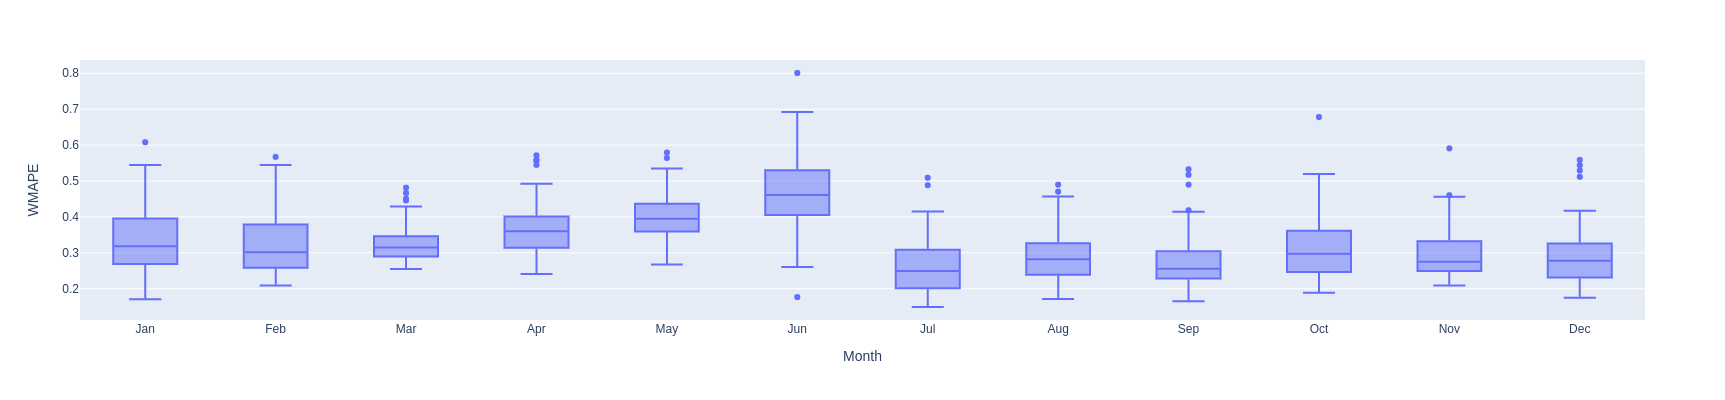

In [38]:
wmape_ = cnn.metrics.df.groupby(["rt_plant_id", "month"]).apply(lambda x: Metrics.calculate_wmape(x["predictions"], x["actuals"]))
wmape_ = wmape_.reset_index().rename(columns={0: "WMAPE", "month":"Month"})
wmape_["Month"] = wmape_["Month"].map(month_dict)
fig = px.box(wmape_, x="Month", y="WMAPE")
# fig = px.violin(wmape_, x="month", y="wmape")
fig.update_xaxes(categoryorder='array', categoryarray=months)
fig.update_layout(autosize=False, width=1200, height=400)
fig.show()

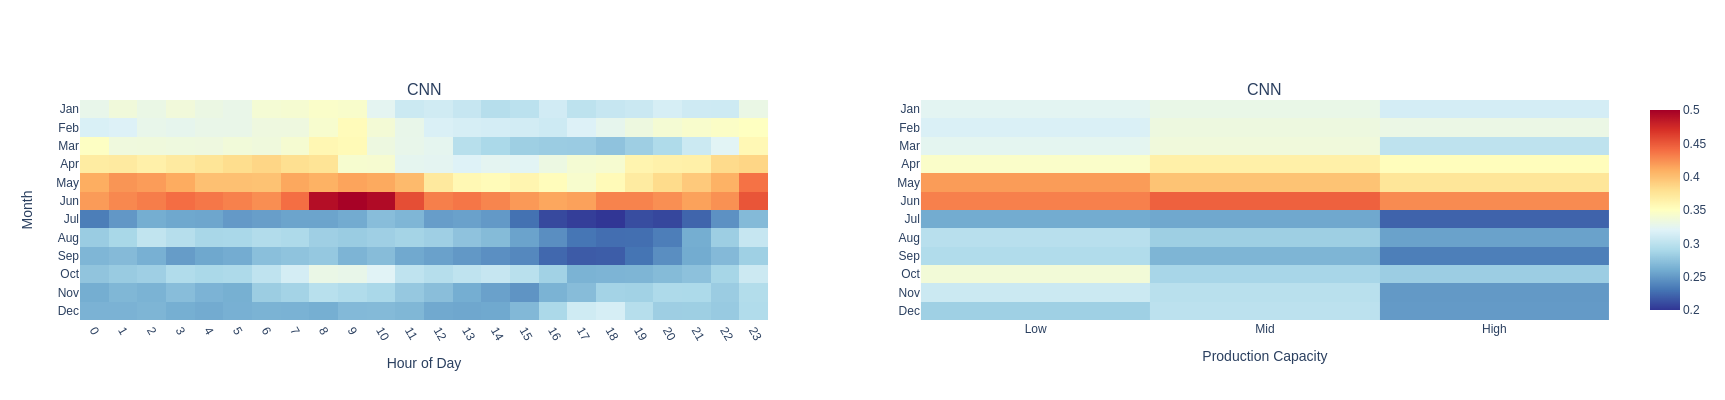

In [40]:
name = "cnn"
model = eval(name)
name = name.upper()

model.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])
data1 = model.fig.data[0]
model.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
data2= model.fig.data[0]

fig = make_subplots(rows=1, cols=2, subplot_titles=[name, name])
fig.add_trace(data1, row=1, col=1)
fig.add_trace(data2, row=1, col=2)

fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=800, height=400, coloraxis_colorscale=COLORS)
fig.update_layout(xaxis=dict(side="bottom", tickmode="linear", tickangle=60), xaxis2=dict(categoryorder='array', categoryarray=["Low", "Mid", "High"]))
# fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])
fig.update_layout(coloraxis=dict(cmax=0.5, cmin=0.2))

fig['layout']['xaxis']['title']='Hour of Day'
fig['layout']['xaxis2']['title']='Production Capacity'
fig['layout']['yaxis']['title']='Month'

fig.show()

## LSTM

In [23]:
lstm = Mert(["hj4494zp", "3f9mkyat", "10u5ruf3", "zhghndl6"])
lstm_overall, lstm_month, lstm_category, lstm_plant = lstm.generate("lstm")
lstm_overall

wmape     bias model
0  0.335921 -0.04459  lstm

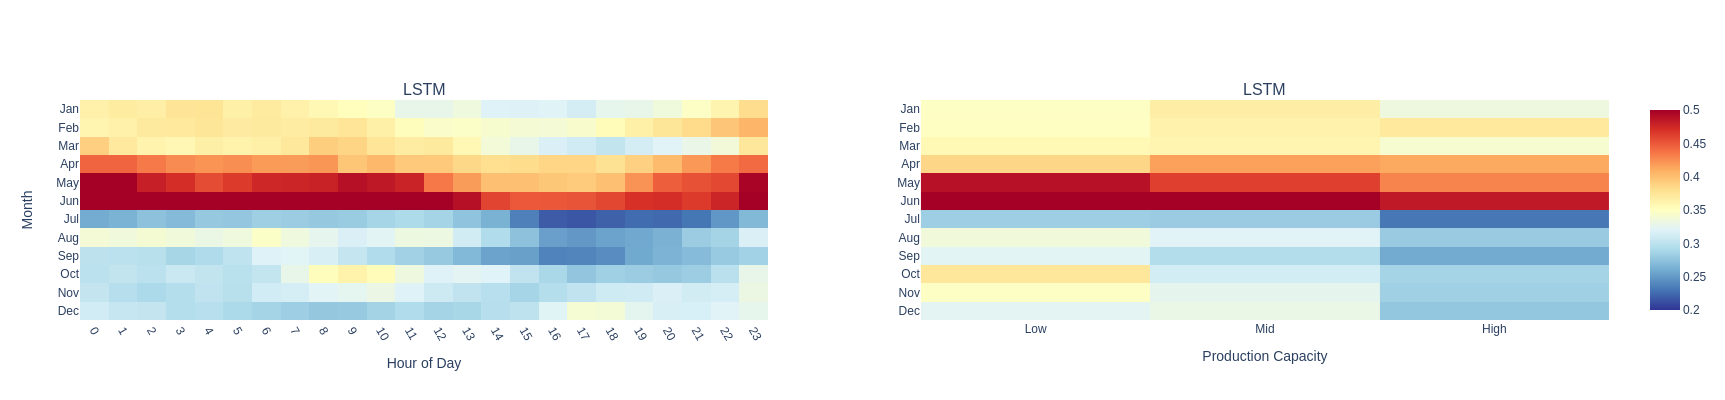

In [41]:
name = "lstm"
model = eval(name)
name = name.upper()

model.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])
data1 = model.fig.data[0]
model.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
data2= model.fig.data[0]

fig = make_subplots(rows=1, cols=2, subplot_titles=[name, name])
fig.add_trace(data1, row=1, col=1)
fig.add_trace(data2, row=1, col=2)

fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=800, height=400, coloraxis_colorscale=COLORS)
fig.update_layout(xaxis=dict(side="bottom", tickmode="linear", tickangle=60), xaxis2=dict(categoryorder='array', categoryarray=["Low", "Mid", "High"]))
# fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])
fig.update_layout(coloraxis=dict(cmax=0.5, cmin=0.2))

fig['layout']['xaxis']['title']='Hour of Day'
fig['layout']['xaxis2']['title']='Production Capacity'
fig['layout']['yaxis']['title']='Month'

fig.show()

In [42]:
# lstm.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])

# lstm.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
# lstm.fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
# lstm.fig.show()

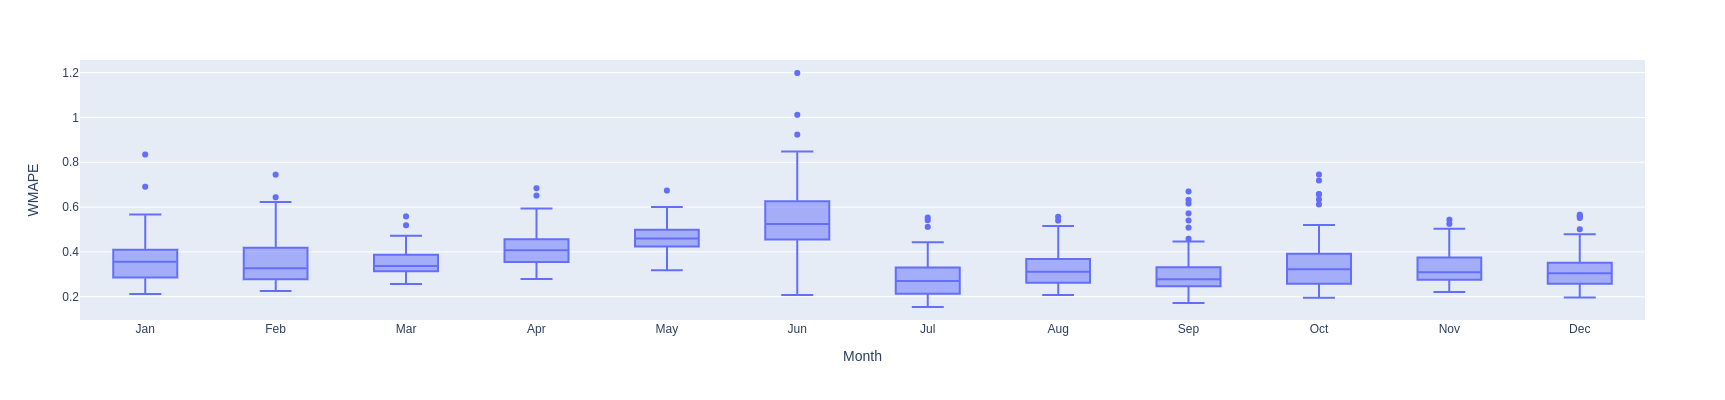

In [43]:
wmape_ = lstm.metrics.df.groupby(["rt_plant_id", "month"]).apply(lambda x: Metrics.calculate_wmape(x["predictions"], x["actuals"]))
wmape_ = wmape_.reset_index().rename(columns={0: "WMAPE", "month":"Month"})
wmape_["Month"] = wmape_["Month"].map(month_dict)
fig = px.box(wmape_, x="Month", y="WMAPE")
# fig = px.violin(wmape_, x="month", y="wmape")
fig.update_xaxes(categoryorder='array', categoryarray=months)
fig.update_layout(autosize=False, width=1200, height=400)
fig.show()

## GCN

In [44]:
gcn = Mert(["15lumdv6", "k3veoutz", "zd8r9nul", "tdedbtwi"])
gcn_overall, gcn_month, gcn_category, gcn_plant = gcn.generate("gcn")
gcn_overall

wmape      bias model
0  0.343227 -0.031277   gcn

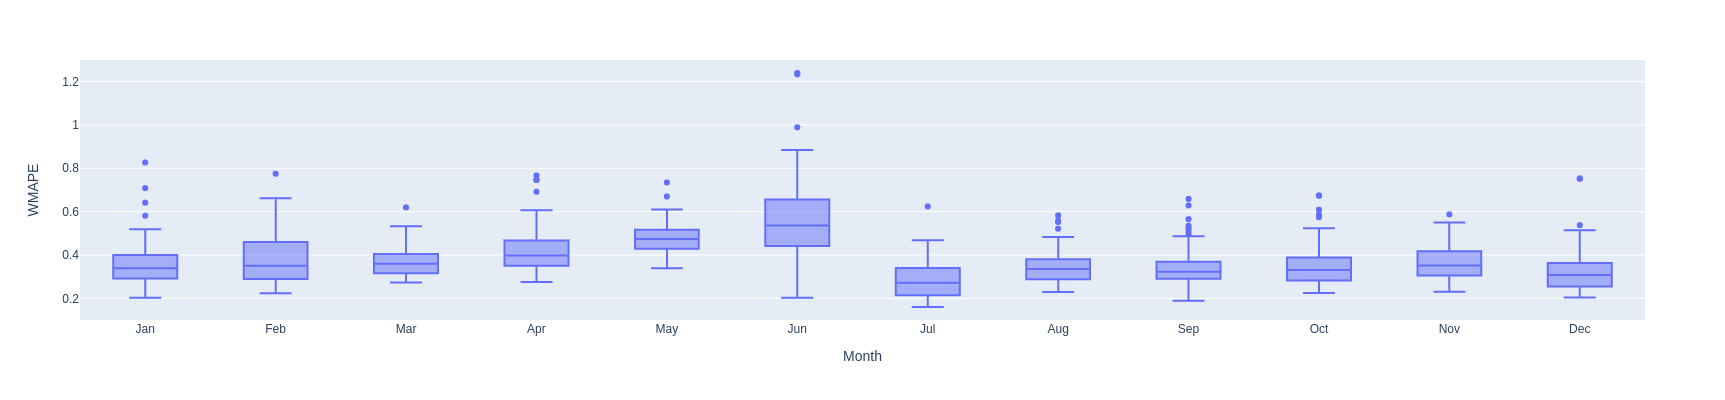

In [45]:
wmape_ = gcn.metrics.df.groupby(["rt_plant_id", "month"]).apply(lambda x: Metrics.calculate_wmape(x["predictions"], x["actuals"]))
wmape_ = wmape_.reset_index().rename(columns={0: "WMAPE", "month":"Month"})
wmape_["Month"] = wmape_["Month"].map(month_dict)
fig = px.box(wmape_, x="Month", y="WMAPE")
# fig = px.violin(wmape_, x="month", y="wmape")
fig.update_xaxes(categoryorder='array', categoryarray=months)
fig.update_layout(autosize=False, width=1200, height=400)
fig.show()

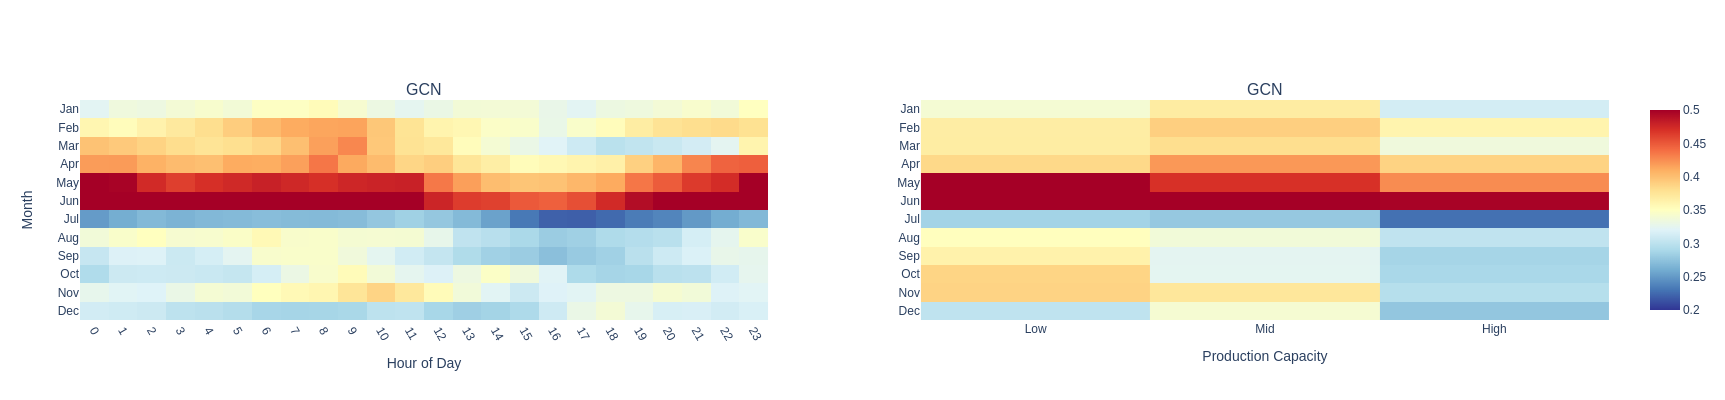

In [46]:
name = "gcn"
model = eval(name)
name = name.upper()

model.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])
data1 = model.fig.data[0]
model.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
data2= model.fig.data[0]

fig = make_subplots(rows=1, cols=2, subplot_titles=[name, name])
fig.add_trace(data1, row=1, col=1)
fig.add_trace(data2, row=1, col=2)

fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=800, height=400, coloraxis_colorscale=COLORS)
fig.update_layout(xaxis=dict(side="bottom", tickmode="linear", tickangle=60), xaxis2=dict(categoryorder='array', categoryarray=["Low", "Mid", "High"]))
# fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])
fig.update_layout(coloraxis=dict(cmax=0.5, cmin=0.2))

fig['layout']['xaxis']['title']='Hour of Day'
fig['layout']['xaxis2']['title']='Production Capacity'
fig['layout']['yaxis']['title']='Month'

fig.show()

## CNN-LSTM

In [47]:
cnnlstm = Mert(["jlmkr7nu", "32978v2g", "1n06n09w", "3giyf1gv"])
cnnlstm_overall, cnnlstm_month, cnnlstm_category, cnnlstm_plant = cnnlstm.generate("cnnlstm")
cnnlstm_overall

wmape      bias    model
0  0.307795 -0.028593  cnnlstm

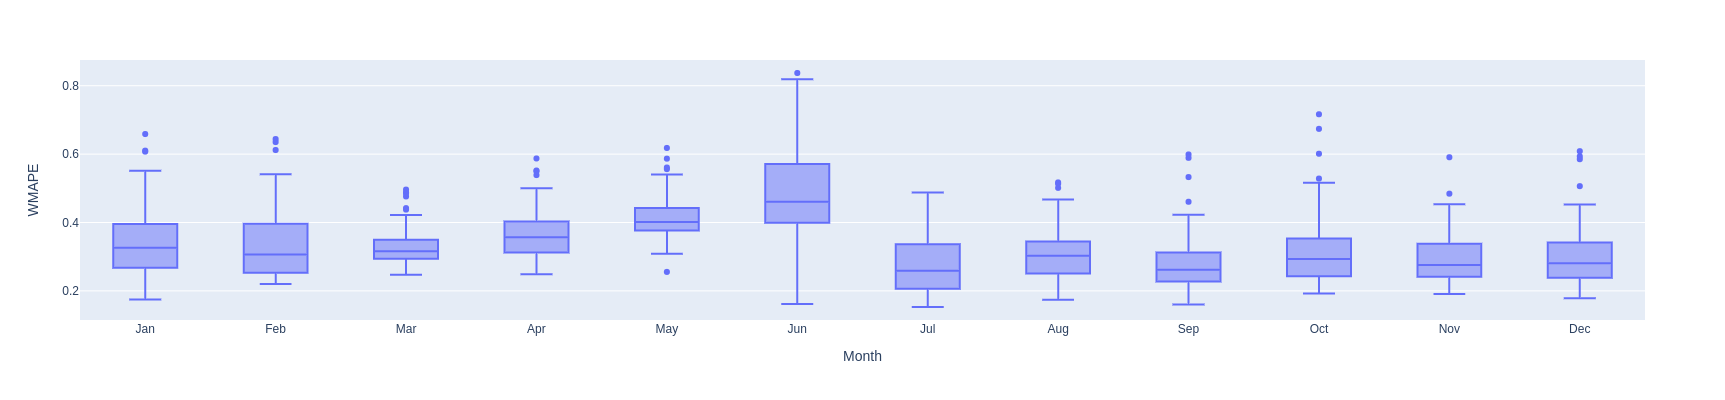

In [48]:
wmape_ = cnnlstm.metrics.df.groupby(["rt_plant_id", "month"]).apply(lambda x: Metrics.calculate_wmape(x["predictions"], x["actuals"]))
wmape_ = wmape_.reset_index().rename(columns={0: "WMAPE", "month":"Month"})
wmape_["Month"] = wmape_["Month"].map(month_dict)
fig = px.box(wmape_, x="Month", y="WMAPE")
# fig = px.violin(wmape_, x="month", y="wmape")
fig.update_xaxes(categoryorder='array', categoryarray=months)
fig.update_layout(autosize=False, width=1200, height=400)
fig.show()

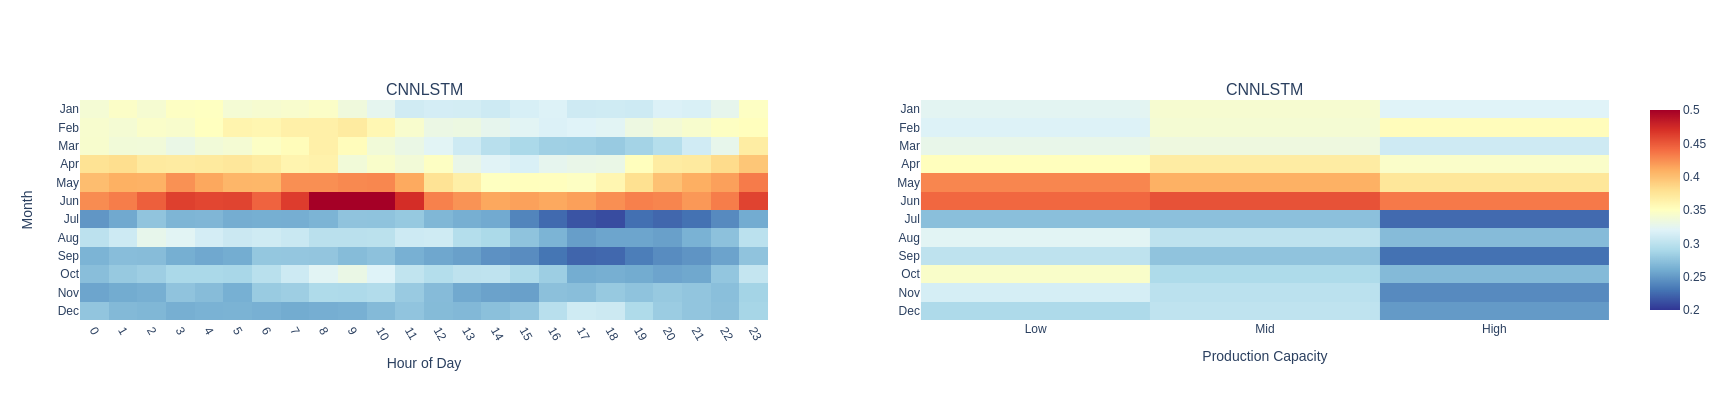

In [56]:
name = "cnnlstm"
model = eval(name)
name = name.upper()

model.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])
data1 = model.fig.data[0]
model.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
data2= model.fig.data[0]

fig = make_subplots(rows=1, cols=2, subplot_titles=[name, name])
fig.add_trace(data1, row=1, col=1)
fig.add_trace(data2, row=1, col=2)

fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=800, height=400, coloraxis_colorscale=COLORS)
fig.update_layout(xaxis=dict(side="bottom", tickmode="linear", tickangle=60), xaxis2=dict(categoryorder='array', categoryarray=["Low", "Mid", "High"]))
# fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])
fig.update_layout(coloraxis=dict(cmax=0.5, cmin=0.2))

fig['layout']['xaxis']['title']='Hour of Day'
fig['layout']['xaxis2']['title']='Production Capacity'
fig['layout']['yaxis']['title']='Month'

fig.show()

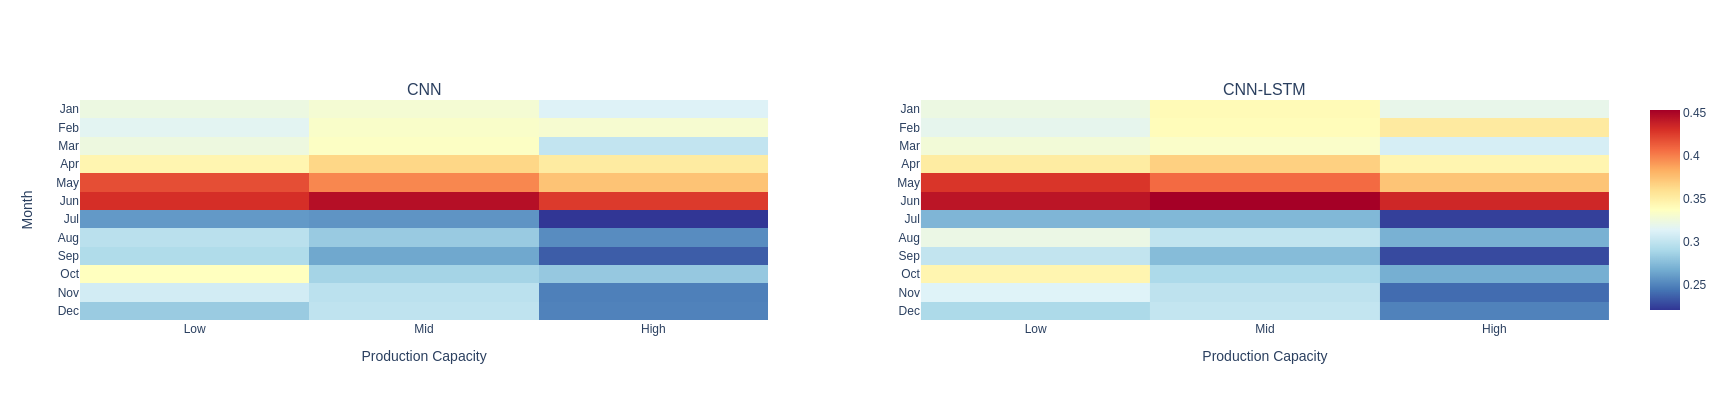

In [51]:
cnn.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
cnnlstm.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])

fig = make_subplots(rows=1, cols=2, subplot_titles=["CNN", "CNN-LSTM"])
fig.add_trace(cnn.fig.data[0], row=1, col=1)
fig.add_trace(cnnlstm.fig.data[0], row=1, col=2)

fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=800, height=400, coloraxis_colorscale=COLORS)
fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])

fig['layout']['xaxis']['title']='Production Capacity'
fig['layout']['xaxis2']['title']='Production Capacity'
fig['layout']['yaxis']['title']='Month'

fig.show()

## ConvLSTM

In [52]:
convlstm = Mert(["1kc87ka8", "1i8xmkm0", "1t9a1hee", "1x8fqcxy"])
convlstm_overall, convlstm_month, convlstm_category, convlstm_plant = convlstm.generate("convlstm")
convlstm_overall

wmape      bias     model
0  0.306025 -0.061681  convlstm

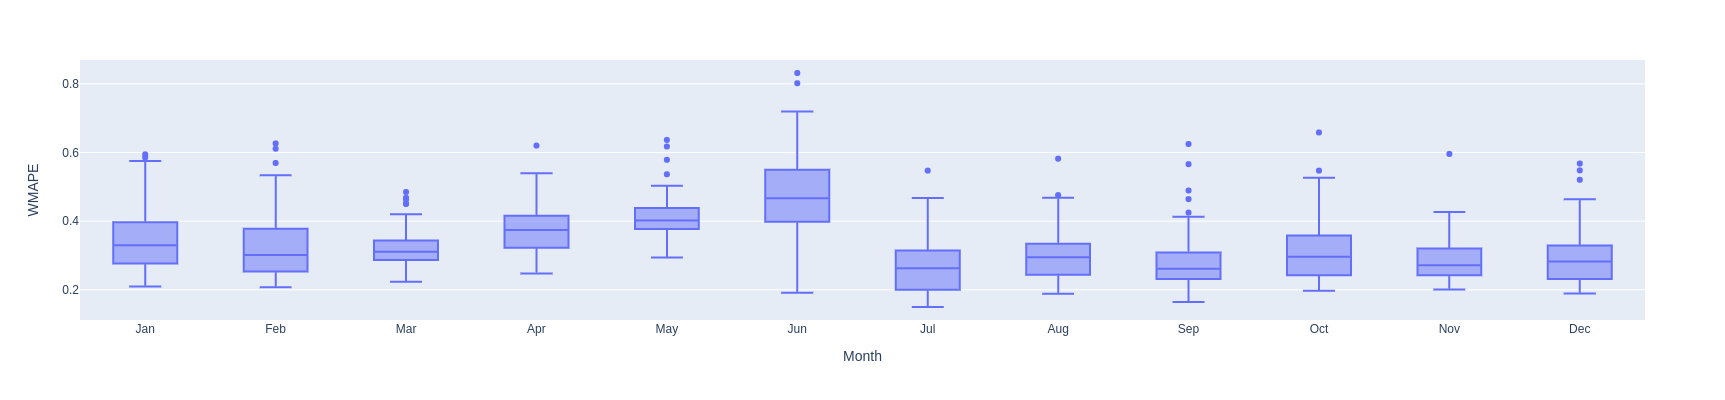

In [53]:
wmape_ = convlstm.metrics.df.groupby(["rt_plant_id", "month"]).apply(lambda x: Metrics.calculate_wmape(x["predictions"], x["actuals"]))
wmape_ = wmape_.reset_index().rename(columns={0: "WMAPE", "month":"Month"})
wmape_["Month"] = wmape_["Month"].map(month_dict)
fig = px.box(wmape_, x="Month", y="WMAPE")
# fig = px.violin(wmape_, x="month", y="wmape")
fig.update_xaxes(categoryorder='array', categoryarray=months)
fig.update_layout(autosize=False, width=1200, height=400)
fig.show()

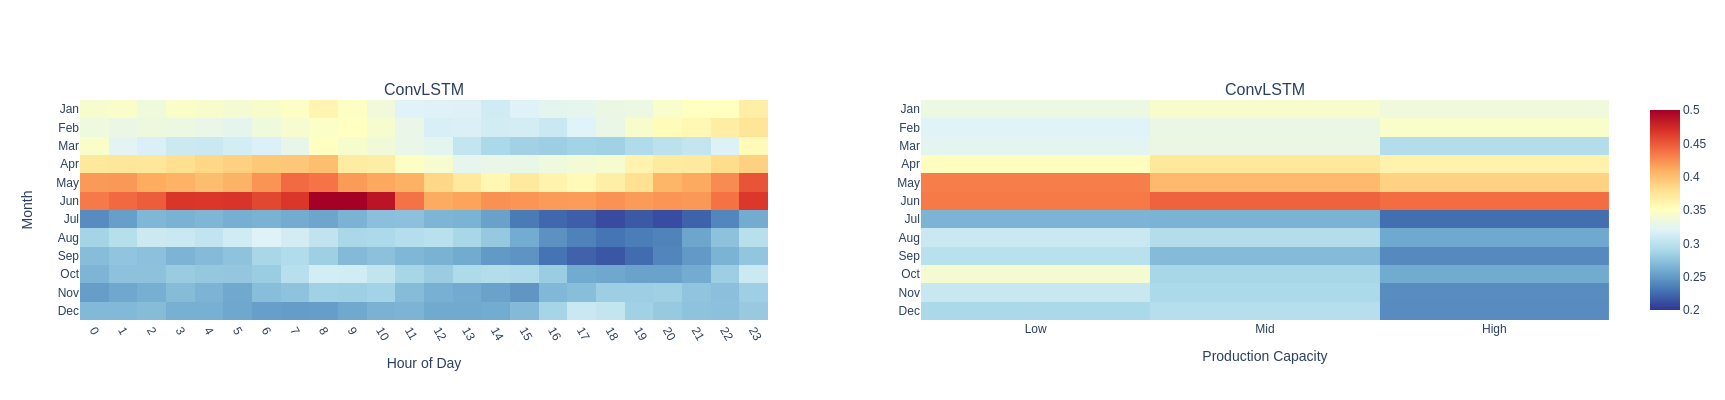

In [84]:
name = "convlstm"
model = eval(name)
name = name.upper()

model.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])
data1 = model.fig.data[0]
model.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
data2= model.fig.data[0]

fig = make_subplots(rows=1, cols=2, subplot_titles=["ConvLSTM", "ConvLSTM"])
fig.add_trace(data1, row=1, col=1)
fig.add_trace(data2, row=1, col=2)

fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=800, height=400, coloraxis_colorscale=COLORS)
fig.update_layout(xaxis=dict(side="bottom", tickmode="linear", tickangle=60), xaxis2=dict(categoryorder='array', categoryarray=["Low", "Mid", "High"]))
# fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])
fig.update_layout(coloraxis=dict(cmax=0.5, cmin=0.2))

fig['layout']['xaxis']['title']='Hour of Day'
fig['layout']['xaxis2']['title']='Production Capacity'
fig['layout']['yaxis']['title']='Month'

fig.show()

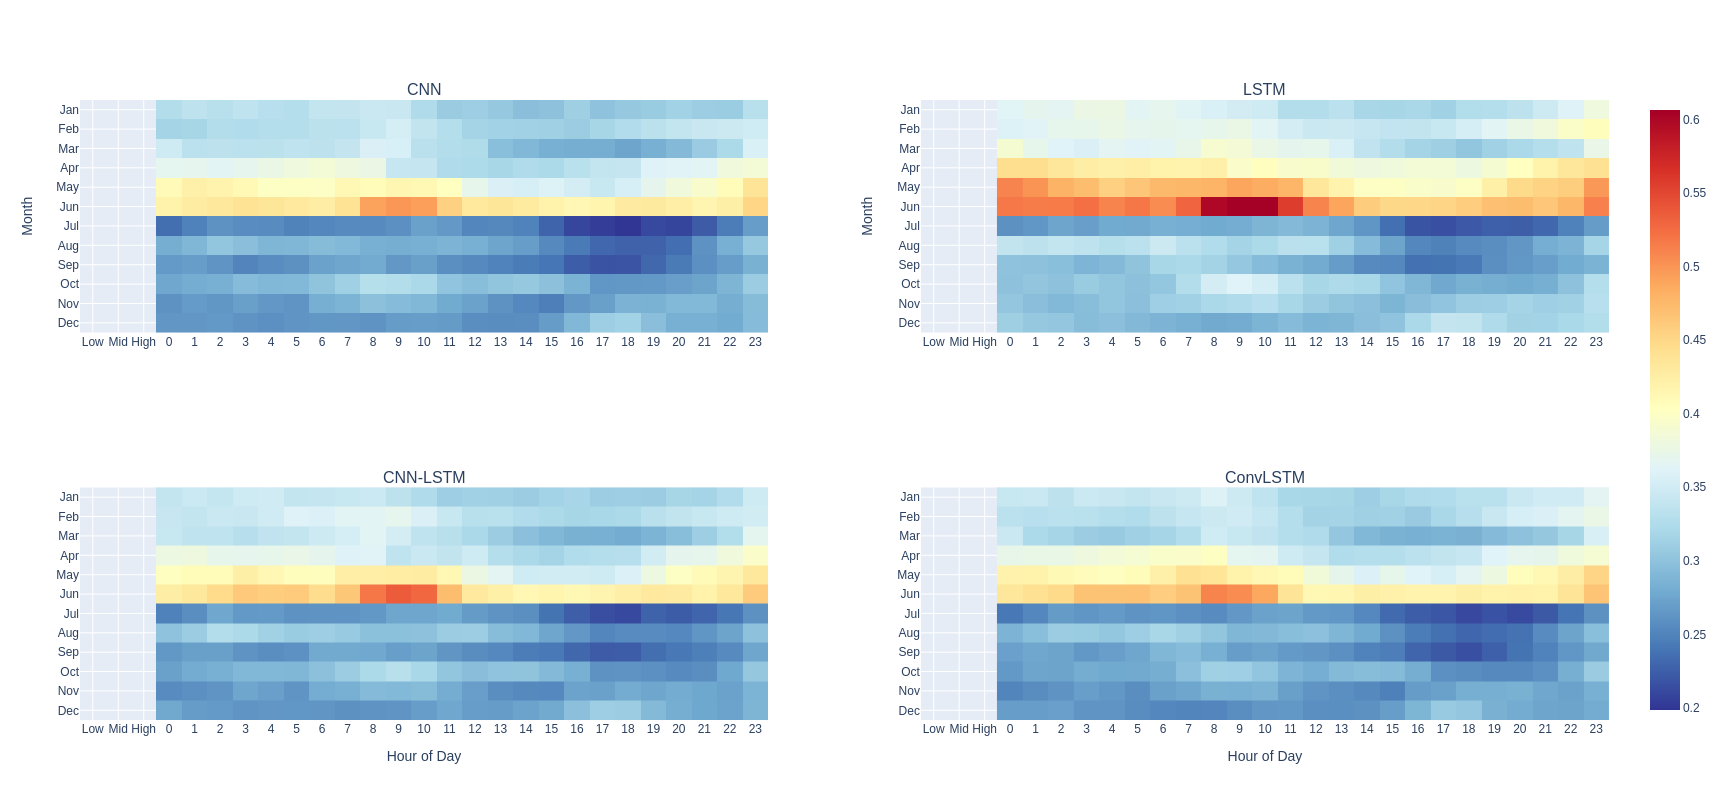

In [83]:
cnn.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])
lstm.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])
cnnlstm.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])
convlstm.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])

fig = make_subplots(rows=2, cols=2, subplot_titles=["CNN", "LSTM", "CNN-LSTM", "ConvLSTM"])
fig.add_trace(cnn.fig.data[0], row=1, col=1)
fig.add_trace(lstm.fig.data[0], row=1, col=2)
fig.add_trace(cnnlstm.fig.data[0], row=2, col=1)
fig.add_trace(convlstm.fig.data[0], row=2, col=2)

fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=800, height=800, coloraxis_colorscale=COLORS)
fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])

fig['layout']['xaxis3']['title']='Hour of Day'
fig['layout']['xaxis4']['title']='Hour of Day'
fig['layout']['yaxis']['title']='Month'
fig['layout']['yaxis2']['title']='Month'

fig.show()

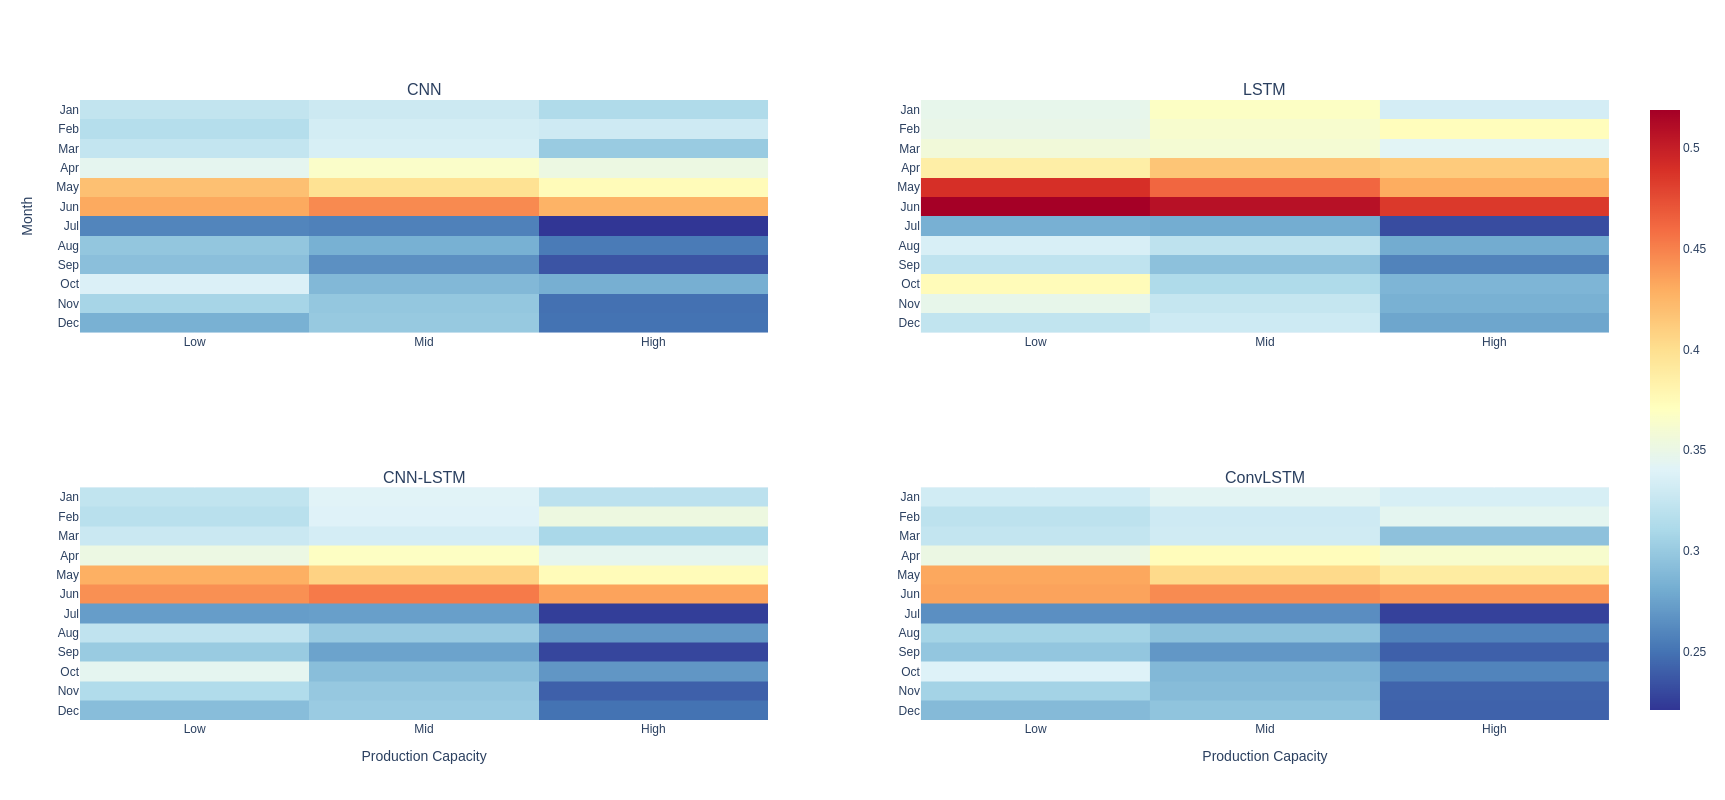

In [86]:
cnn.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
lstm.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
cnnlstm.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
convlstm.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])

fig = make_subplots(rows=2, cols=2, subplot_titles=["CNN", "LSTM", "CNN-LSTM", "ConvLSTM"])
fig.add_trace(cnn.fig.data[0], row=1, col=1)
fig.add_trace(lstm.fig.data[0], row=1, col=2)
fig.add_trace(cnnlstm.fig.data[0], row=2, col=1)
fig.add_trace(convlstm.fig.data[0], row=2, col=2)

fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=800, height=800, coloraxis_colorscale=COLORS)
fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])

fig['layout']['xaxis3']['title']='Production Capacity'
fig['layout']['xaxis4']['title']='Production Capacity'
fig['layout']['yaxis']['title']='Month'
fig['layout']['yaxis']['title']='Month'

fig.show()

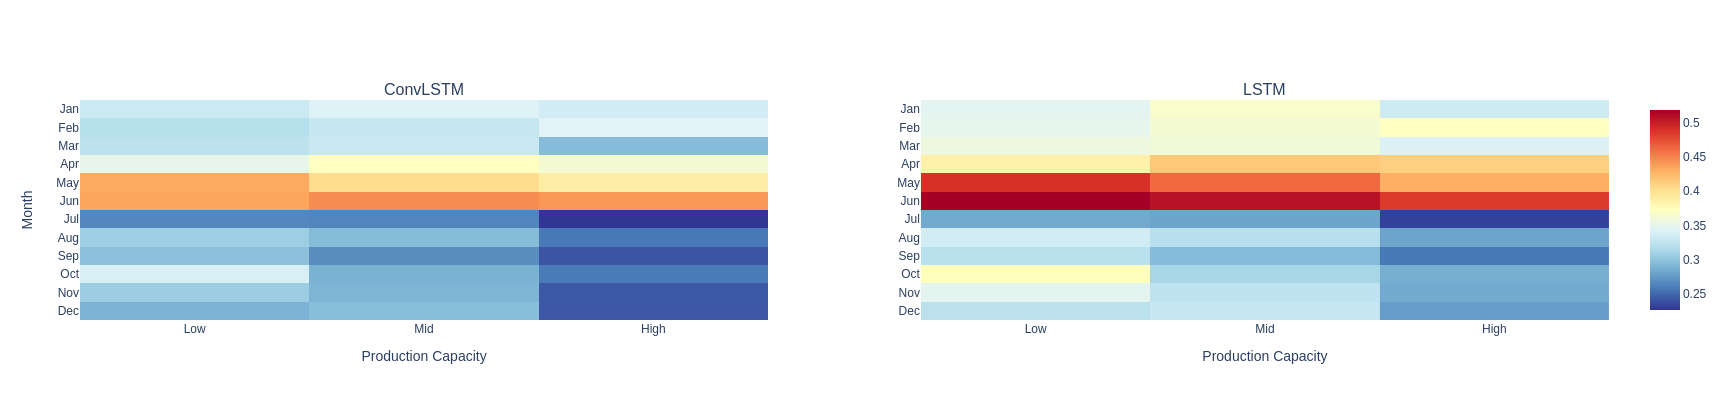

In [87]:
lstm.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
convlstm.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])

fig = make_subplots(rows=1, cols=2, subplot_titles=["ConvLSTM", "LSTM"])
fig.add_trace(lstm.fig.data[0], row=1, col=2)
fig.add_trace(convlstm.fig.data[0], row=1, col=1)

fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=800, height=400, coloraxis_colorscale=COLORS)
fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])

fig['layout']['xaxis']['title']='Production Capacity'
fig['layout']['xaxis2']['title']='Production Capacity'
fig['layout']['yaxis']['title']='Month'

fig.show()

## LGB

In [57]:
lgb = pd.read_csv("/home/mert/Desktop/thesis/data/out/lightgbm_output.csv")
lgb["forecast_dt"] = pd.to_datetime(lgb["forecast_dt"])
lgb["category"] = lgb.rt_plant_id.map(plant_dict)
lgb["month"] = lgb["forecast_dt"].dt.month
name = "lgb"; lgb_metrics = Metrics(lgb); lgb_metrics.calculate()
lgb_overall, lgb_month, lgb_category, lgb_plant = lgb_metrics.to_df(name, "overall"), lgb_metrics.to_df(name, "month"), lgb_metrics.to_df(name, "category"), lgb_metrics.to_df(name, "rt_plant_id")
lgb_overall

wmape     bias model
0  0.342362 -0.05357   lgb

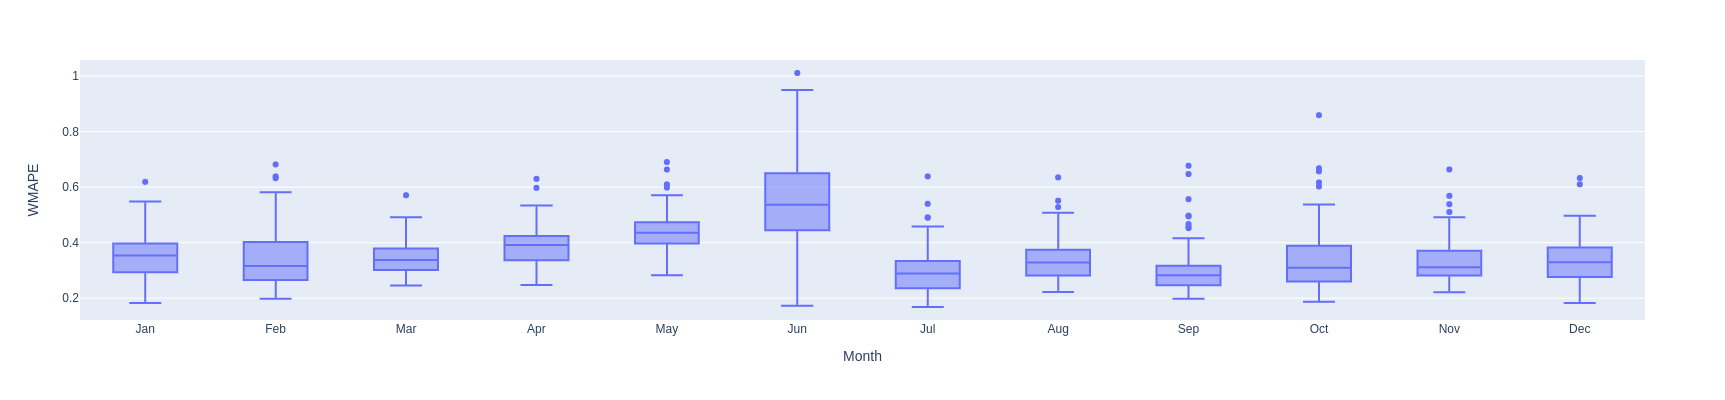

In [58]:
wmape_ = lgb_metrics.df.groupby(["rt_plant_id", "month"]).apply(lambda x: Metrics.calculate_wmape(x["predictions"], x["actuals"]))
wmape_ = wmape_.reset_index().rename(columns={0: "WMAPE", "month":"Month"})
wmape_["Month"] = wmape_["Month"].map(month_dict)
fig = px.box(wmape_, x="Month", y="WMAPE")
# fig = px.violin(wmape_, x="month", y="wmape")
fig.update_xaxes(categoryorder='array', categoryarray=months)
fig.update_layout(autosize=False, width=1200, height=400)
fig.show()

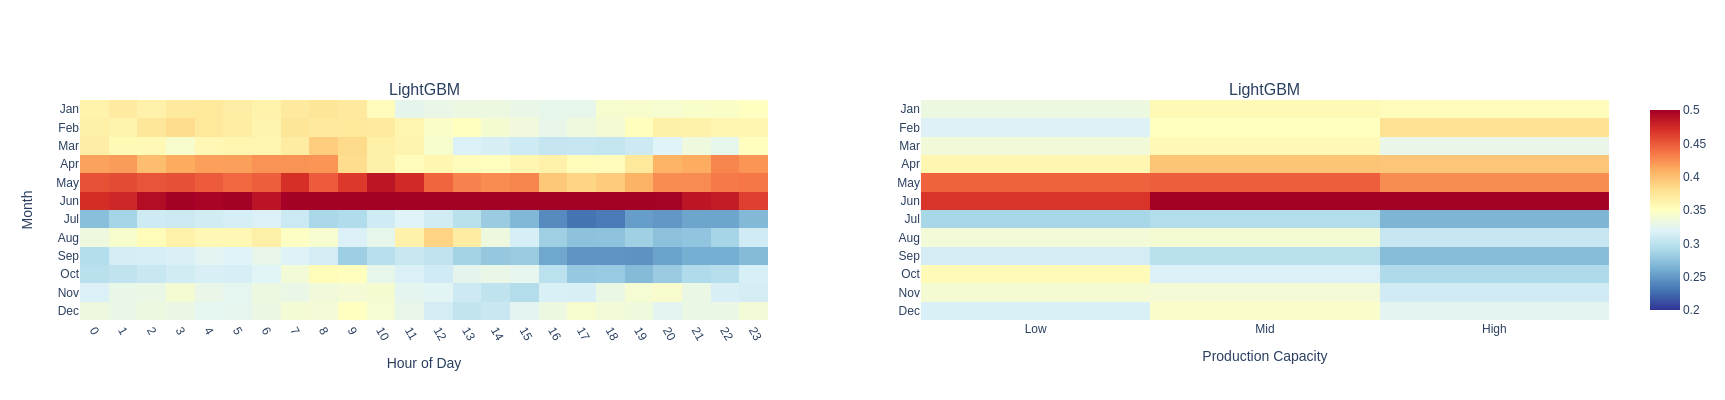

In [62]:
lgb_metrics.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])
data1 = lgb_metrics.fig.data[0]
lgb_metrics.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
data2= lgb_metrics.fig.data[0]

fig = make_subplots(rows=1, cols=2, subplot_titles=["LightGBM"]*2)
fig.add_trace(data1, row=1, col=1)
fig.add_trace(data2, row=1, col=2)

fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=800, height=400, coloraxis_colorscale=COLORS)
fig.update_layout(xaxis=dict(side="bottom", tickmode="linear", tickangle=60), xaxis2=dict(categoryorder='array', categoryarray=["Low", "Mid", "High"]))
# fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])
fig.update_layout(coloraxis=dict(cmax=0.5, cmin=0.2))

fig['layout']['xaxis']['title']='Hour of Day'
fig['layout']['xaxis2']['title']='Production Capacity'
fig['layout']['yaxis']['title']='Month'

fig.show()

## P24

In [64]:
p_24 = pd.read_csv("/home/mert/Desktop/thesis/data/out/persistence24_output.csv")
p_24["forecast_dt"] = pd.to_datetime(p_24["forecast_dt"])
p_24["category"] = p_24.rt_plant_id.map(plant_dict)
p_24["month"] = p_24["forecast_dt"].dt.month
name = "p_24"; p_24_metrics = Metrics(p_24); p_24_metrics.calculate()
p_24_overall, p_24_month, p_24_category, p_24_plant = p_24_metrics.to_df(name, "overall"), p_24_metrics.to_df(name, "month"), p_24_metrics.to_df(name, "category"), p_24_metrics.to_df(name, "rt_plant_id")
p_24_overall

wmape      bias model
0  0.701161  0.000185  p_24

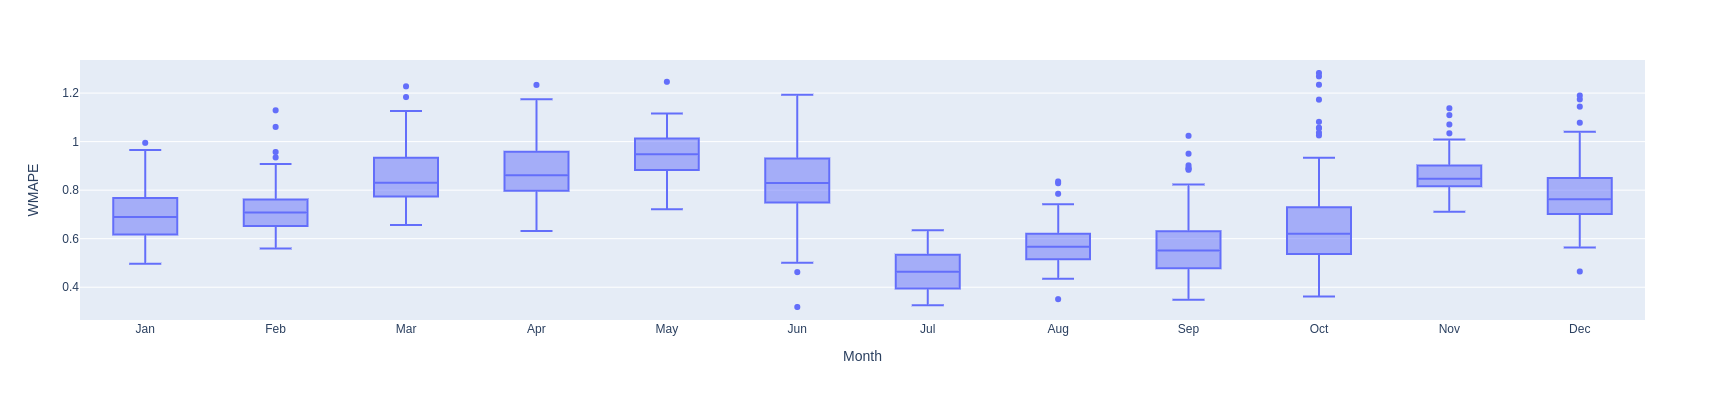

In [65]:
wmape_ = p_24_metrics.df.groupby(["rt_plant_id", "month"]).apply(lambda x: Metrics.calculate_wmape(x["predictions"], x["actuals"]))
wmape_ = wmape_.reset_index().rename(columns={0: "WMAPE", "month":"Month"})
wmape_["Month"] = wmape_["Month"].map(month_dict)
fig = px.box(wmape_, x="Month", y="WMAPE")
# fig = px.violin(wmape_, x="month", y="wmape")
fig.update_xaxes(categoryorder='array', categoryarray=months)
fig.update_layout(autosize=False, width=1200, height=400)
fig.show()

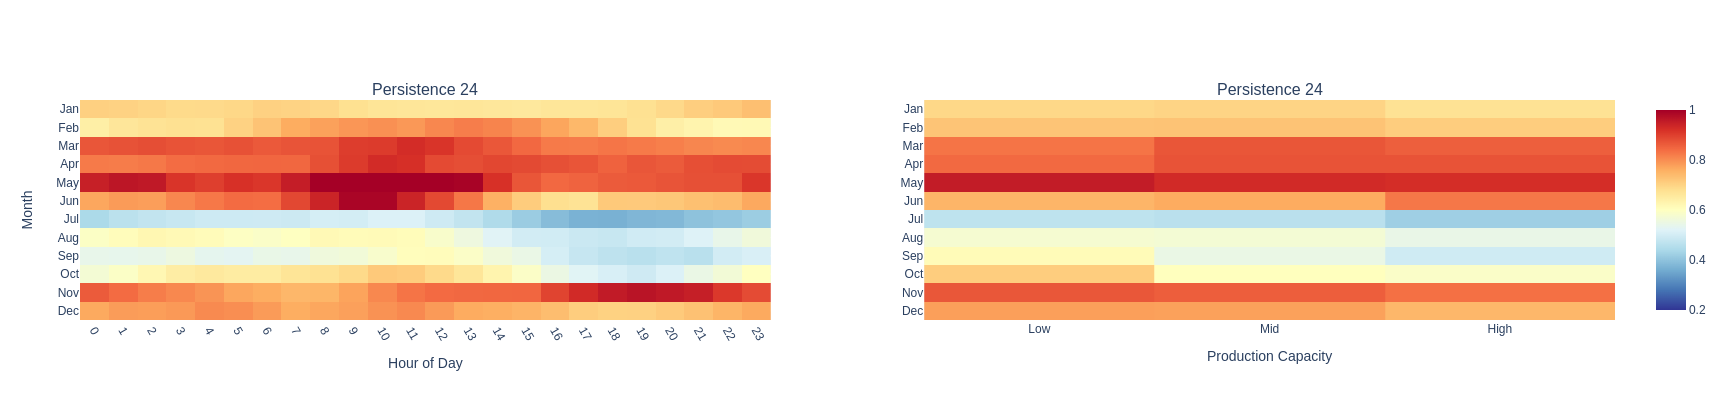

In [82]:
p_24_metrics.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])
data1 = p_24_metrics.fig.data[0]
p_24_metrics.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
data2= p_24_metrics.fig.data[0]

fig = make_subplots(rows=1, cols=2, subplot_titles=["Persistence 24"]*2)
fig.add_trace(data1, row=1, col=1)
fig.add_trace(data2, row=1, col=2)

fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=800, height=400, coloraxis_colorscale=COLORS)
fig.update_layout(xaxis=dict(side="bottom", tickmode="linear", tickangle=60), xaxis2=dict(categoryorder='array', categoryarray=["Low", "Mid", "High"]))
# fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])
fig.update_layout(coloraxis=dict(cmax=1, cmin=0.2))

fig['layout']['xaxis']['title']='Hour of Day'
fig['layout']['xaxis2']['title']='Production Capacity'
fig['layout']['yaxis']['title']='Month'

fig.show()

## P48

In [70]:
p_48 = pd.read_csv("/home/mert/Desktop/thesis/data/out/persistence48_output.csv")
p_48["forecast_dt"] = pd.to_datetime(p_48["forecast_dt"])
p_48["category"] = p_48.rt_plant_id.map(plant_dict)
p_48["month"] = p_48["forecast_dt"].dt.month
name = "p_48"; p_48_metrics = Metrics(p_48); p_48_metrics.calculate()
p_48_overall, p_48_month, p_48_category, p_48_plant = p_48_metrics.to_df(name, "overall"), p_48_metrics.to_df(name, "month"), p_48_metrics.to_df(name, "category"), p_48_metrics.to_df(name, "rt_plant_id")
p_48_overall

wmape      bias model
0  0.88809  0.001085  p_48

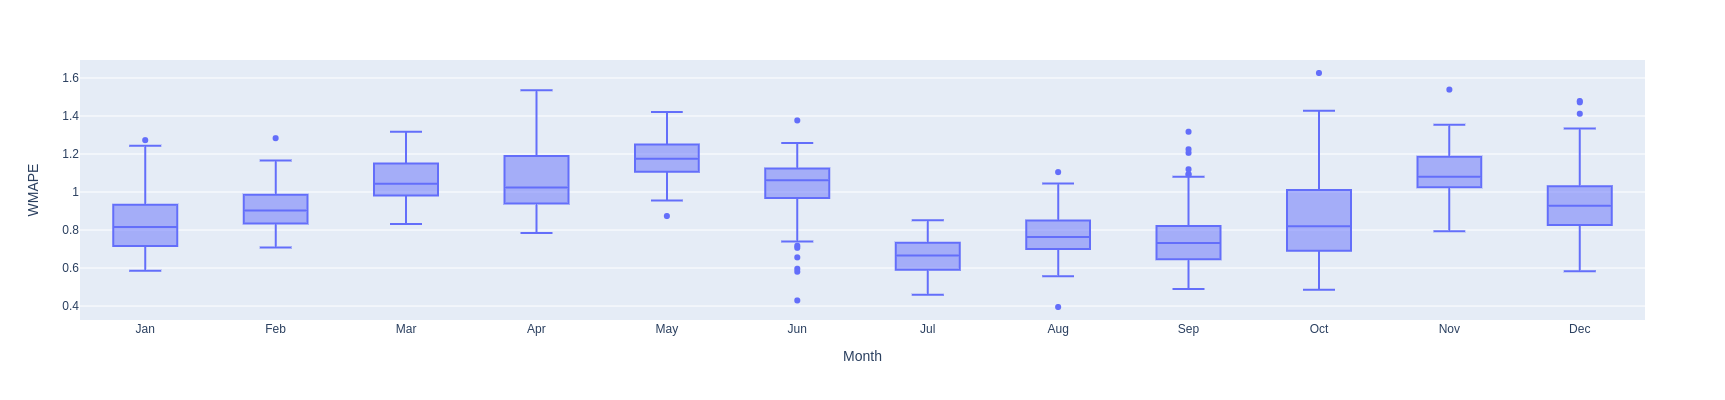

In [71]:
wmape_ = p_48_metrics.df.groupby(["rt_plant_id", "month"]).apply(lambda x: Metrics.calculate_wmape(x["predictions"], x["actuals"]))
wmape_ = wmape_.reset_index().rename(columns={0: "WMAPE", "month":"Month"})
wmape_["Month"] = wmape_["Month"].map(month_dict)
fig = px.box(wmape_, x="Month", y="WMAPE")
# fig = px.violin(wmape_, x="month", y="wmape")
fig.update_xaxes(categoryorder='array', categoryarray=months)
fig.update_layout(autosize=False, width=1200, height=400)
fig.show()

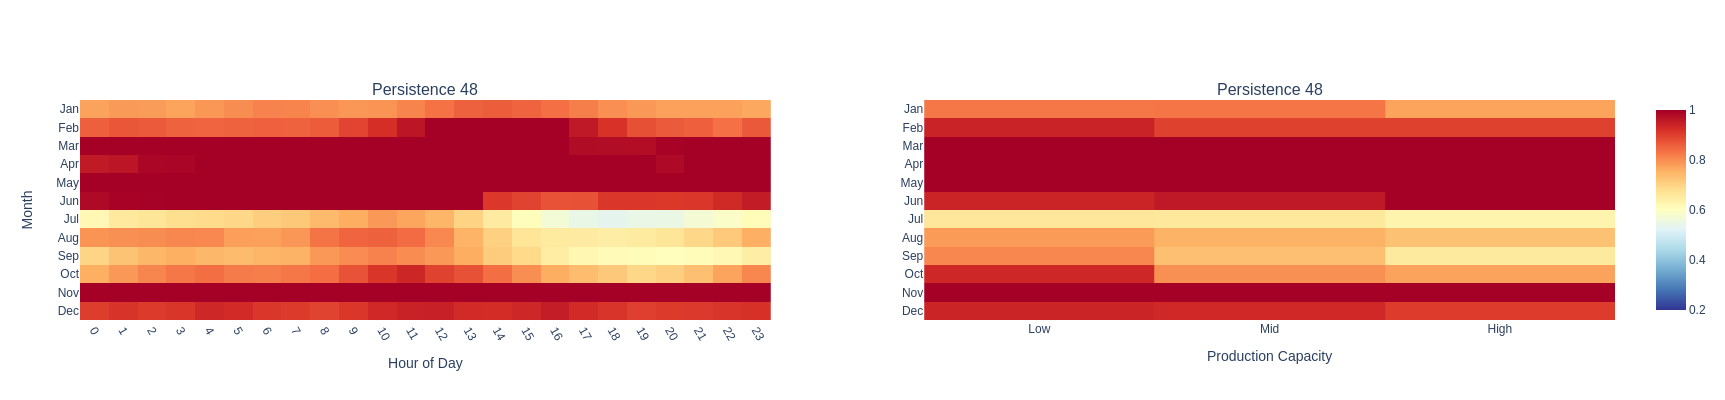

In [81]:
p_48_metrics.plot_heatmap(which="hour", linear=True, range_color=[0.2, 0.6])
data1 = p_48_metrics.fig.data[0]
p_48_metrics.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
data2= p_48_metrics.fig.data[0]

fig = make_subplots(rows=1, cols=2, subplot_titles=["Persistence 48"]*2)
fig.add_trace(data1, row=1, col=1)
fig.add_trace(data2, row=1, col=2)

fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=800, height=400, coloraxis_colorscale=COLORS)
fig.update_layout(xaxis=dict(side="bottom", tickmode="linear", tickangle=60), xaxis2=dict(categoryorder='array', categoryarray=["Low", "Mid", "High"]))
# fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])
fig.update_layout(coloraxis=dict(cmax=1, cmin=0.2))

fig['layout']['xaxis']['title']='Hour of Day'
fig['layout']['xaxis2']['title']='Production Capacity'
fig['layout']['yaxis']['title']='Month'

fig.show()

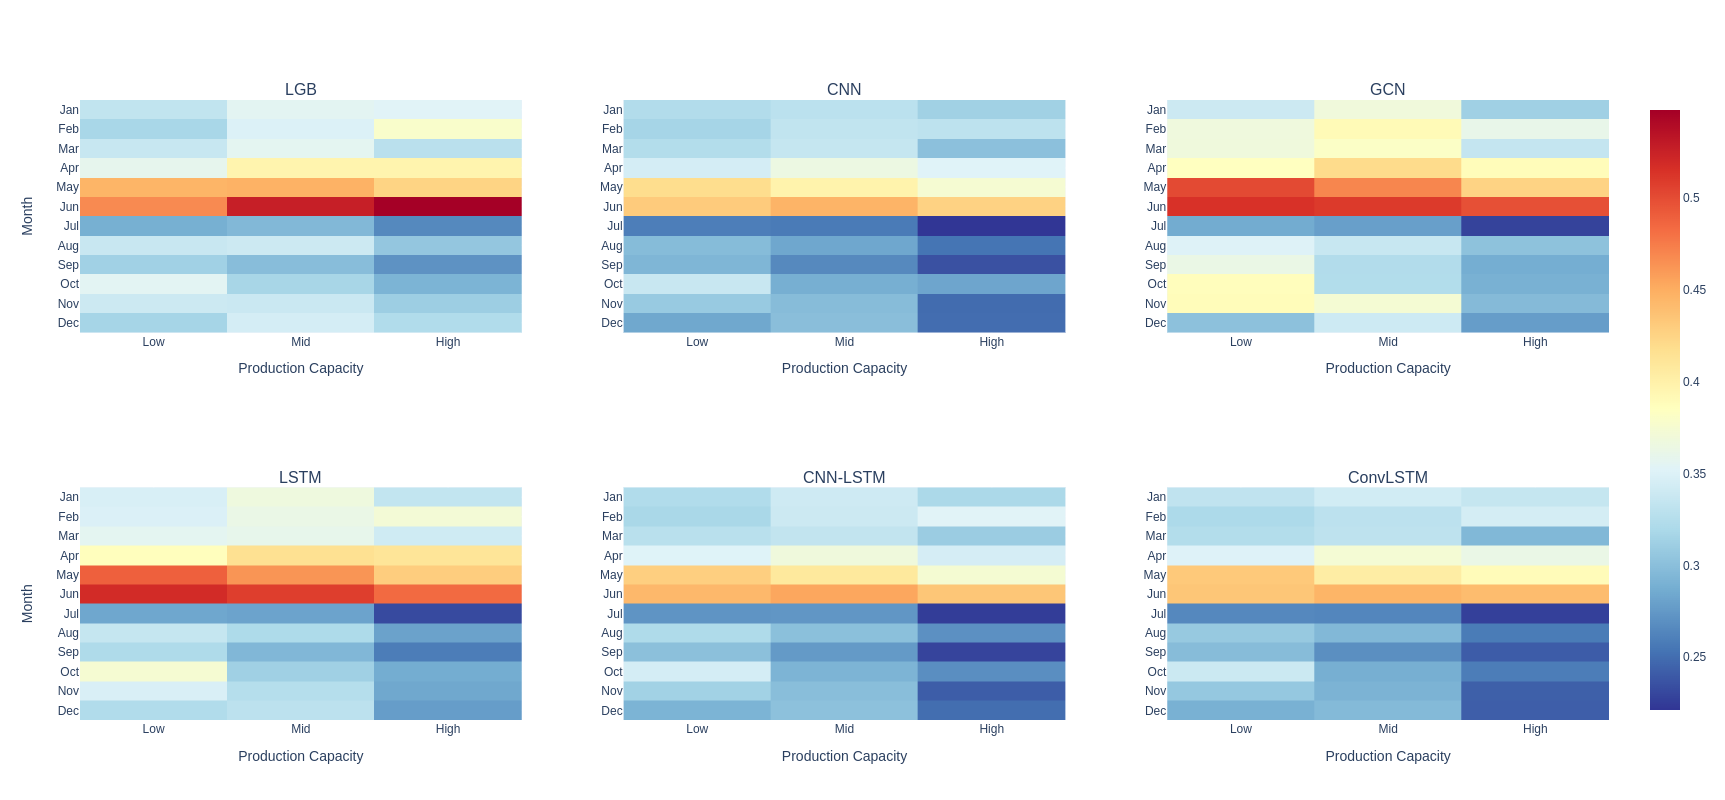

In [93]:
lgb_metrics.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
cnn.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
gcn.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
lstm.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
cnnlstm.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])
convlstm.plot_heatmap(which="category", linear=True, range_color=[0.2, 0.6])

fig = make_subplots(rows=2, cols=3, subplot_titles=["LGB", "CNN", "GCN", "LSTM", "CNN-LSTM", "ConvLSTM"])
fig.add_trace(lgb_metrics.fig.data[0], row=1, col=1)
fig.add_trace(cnn.fig.data[0], row=1, col=2)
fig.add_trace(gcn.fig.data[0], row=1, col=3)
fig.add_trace(lstm.fig.data[0], row=2, col=1)
fig.add_trace(cnnlstm.fig.data[0], row=2, col=2)
fig.add_trace(convlstm.fig.data[0], row=2, col=3)

fig.update_layout(coloraxis_autocolorscale=False, autosize=False, width=1000, height=800, coloraxis_colorscale=COLORS)
fig.update_xaxes(side="bottom", tickmode="linear", tickangle=0, categoryorder='array', categoryarray=["Low", "Mid", "High"])
fig.update_yaxes(categoryorder='array', categoryarray=months[::-1])

for i in range(1,7):
    fig['layout'][f'xaxis{i}']['title']='Production Capacity'
fig['layout']['yaxis']['title']='Month'
fig['layout']['yaxis4']['title']='Month'

fig.show()

In [57]:
overall

wmape      bias     model
0  0.302746 -0.050161       cnn
0  0.306025 -0.061681  convlstm
0  0.307795 -0.028593   cnnlstm
0  0.335921 -0.044590      lstm
0  0.342362 -0.053570       lgb
0  0.343227 -0.031277       gcn
0  0.349027 -0.034812       mlp
0  0.373116 -0.034957      mlp2
0  0.701161  0.000185      p_24
0  0.888090  0.001085      p_48

In [43]:
models = ["mlp", "cnn", "lstm", "gcn", "cnnlstm", "convlstm", "mlp2", "lgb", "p_24", "p_48"] # , "mlp2_48", "mlp_48"
# models = ["mlp", "cnn", "lstm", "gcn", "cnnlstm", "convlstm", "mlp2", "lgb", "p_24", "p_48", "mlp2_60", "mlp_60"] # , "p_1"

In [45]:
overall = pd.concat([eval(f"{m}_overall") for m in models]).sort_values("wmape")
print(overall.to_latex())

\begin{tabular}{lrrl}
\toprule
{} &     wmape &      bias &     model \\
\midrule
0 &  0.302746 & -0.050161 &       cnn \\
0 &  0.306025 & -0.061681 &  convlstm \\
0 &  0.307795 & -0.028593 &   cnnlstm \\
0 &  0.335921 & -0.044590 &      lstm \\
0 &  0.342362 & -0.053570 &       lgb \\
0 &  0.343227 & -0.031277 &       gcn \\
0 &  0.349027 & -0.034812 &       mlp \\
0 &  0.373116 & -0.034957 &      mlp2 \\
0 &  0.701161 &  0.000185 &      p\_24 \\
0 &  0.888090 &  0.001085 &      p\_48 \\
\bottomrule
\end{tabular}



In [54]:
month = pd.concat([eval(f"{m}_month") for m in models]).sort_values("mwmape_median")
month = month[["model", "mwmape_median", "mwmape_std", "mbias_median", "mbias_std"]]
month["model"] = month["model"].str.upper()
print(month.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
   model &  mwmape\_median &  mwmape\_std &  mbias\_median &  mbias\_std \\
\midrule
CONVLSTM &       0.296828 &    0.061240 &     -0.052155 &   0.049413 \\
     CNN &       0.304623 &    0.057856 &     -0.048069 &   0.032881 \\
 CNNLSTM &       0.305067 &    0.058708 &     -0.020038 &   0.048823 \\
    LSTM &       0.327915 &    0.072433 &     -0.044204 &   0.050147 \\
     LGB &       0.334944 &    0.069019 &     -0.049778 &   0.071166 \\
     GCN &       0.337323 &    0.069228 &     -0.023150 &   0.035216 \\
     MLP &       0.356699 &    0.067536 &     -0.027528 &   0.039392 \\
    MLP2 &       0.373842 &    0.079965 &     -0.036752 &   0.079448 \\
    P\_24 &       0.739961 &    0.154124 &     -0.003213 &   0.036914 \\
    P\_48 &       0.912437 &    0.167233 &      0.011364 &   0.068036 \\
\bottomrule
\end{tabular}



In [49]:
category = pd.concat([eval(f"{m}_category") for m in models]).sort_values("cwmape_median")
category

cwmape_median  cwmape_std  cbias_median  cbias_std     model
0       0.315904    0.017743     -0.039191   0.018297       cnn
0       0.318570    0.018324     -0.049027   0.019438  convlstm
0       0.323216    0.020772     -0.013974   0.022399   cnnlstm
0       0.341521    0.009013     -0.038048   0.026514       lgb
0       0.350523    0.021271     -0.026039   0.026208      lstm
0       0.365711    0.027520     -0.019458   0.017180       gcn
0       0.366871    0.026249     -0.024788   0.013334       mlp
0       0.389082    0.028163     -0.020725   0.019784      mlp2
0       0.710398    0.019380      0.000063   0.000513      p_24
0       0.895850    0.023239      0.001005   0.000987      p_48

In [56]:
plant = pd.concat([eval(f"{m}_plant") for m in models]).sort_values("pwmape_median")
plant = plant[["model", "pwmape_median", "pwmape_std", "pbias_median", "pbias_std"]]
plant["model"] = plant["model"].str.upper()
print(plant.to_latex(index=False))
# plant

\begin{tabular}{lrrrr}
\toprule
   model &  pwmape\_median &  pwmape\_std &  pbias\_median &  pbias\_std \\
\midrule
     CNN &       0.304482 &    0.048104 &     -0.030538 &   0.066221 \\
CONVLSTM &       0.304546 &    0.049443 &     -0.040772 &   0.064716 \\
 CNNLSTM &       0.309527 &    0.052439 &     -0.009024 &   0.069130 \\
    LSTM &       0.335675 &    0.056339 &     -0.019851 &   0.069230 \\
     LGB &       0.336142 &    0.061375 &     -0.017574 &   0.090537 \\
     GCN &       0.346698 &    0.051549 &     -0.036873 &   0.067966 \\
     MLP &       0.347401 &    0.054253 &     -0.043693 &   0.073539 \\
    MLP2 &       0.375717 &    0.063198 &     -0.038514 &   0.102569 \\
    P\_24 &       0.715046 &    0.058094 &      0.000396 &   0.002547 \\
    P\_48 &       0.897398 &    0.068325 &      0.001634 &   0.003569 \\
\bottomrule
\end{tabular}



# Visual

In [127]:
LOW = 1843
MEDIUM = 2323
HIGH = 1518

In [131]:
a = cnn.metrics.df.copy()
a["date"] = a["forecast_dt"].dt.date

In [139]:
# a[a["category"] == "Low"].groupby(["date"])[["actuals", "predictions"]].mean().iloc[:100].plot(figsize=(30,10))

In [140]:
# a[a["category"] == "Mid"].groupby(["date"])[["actuals", "predictions"]].mean().iloc[:100].plot(figsize=(30,10))

In [141]:
# a[a["category"] == "High"].groupby(["date"])[["actuals", "predictions"]].mean().iloc[:100].plot(figsize=(30,10))

# Metrics

In [59]:
dfs = []
for model in models:
    print(model)
    try:
        df = eval(model).metrics.df
    except:
        df = eval(f"{model}_metrics").df
    wmape_ = df.groupby(["rt_plant_id", "month"]).apply(lambda x: Metrics.calculate_wmape(x["predictions"], x["actuals"]))
    wmape_.name = "wmape_" + model
    dfs.append(wmape_)
metrics = pd.concat(dfs, axis=1)
rankings = metrics.rank(1, ascending=True, method='first')

mlp
cnn
lstm
gcn
cnnlstm
convlstm
mlp2
lgb
p_24
p_48


In [60]:
metrics

wmape_mlp  wmape_cnn  wmape_lstm  wmape_gcn  wmape_cnnlstm  \
rt_plant_id month                                                               
672         1       0.309452   0.272360    0.266965   0.303227       0.273151   
            2       0.359602   0.362896    0.357648   0.379110       0.375829   
            3       0.356620   0.291627    0.374395   0.344474       0.309649   
            4       0.484576   0.407854    0.448842   0.467456       0.382216   
            5       0.501769   0.426482    0.498611   0.476231       0.413771   
...                      ...        ...         ...        ...            ...   
2374        8       0.336645   0.306549    0.327538   0.367727       0.331816   
            9       0.452174   0.370520    0.432695   0.512361       0.365676   
            10      0.403088   0.304986    0.400544   0.385075       0.368504   
            11      0.468207   0.310245    0.425637   0.451965       0.332547   
            12      0.316319   0.259321    0.351936   0.313075       0.289968   

                   wmape_convlstm  wmape_mlp2  wmape_lgb  wmape_p_24  \
rt_plant_id month                                                      
672         1            0.248411    0.333032   0.272188    0.657445   
            2            0.348336    0.416369   0.384192    0.720441   
            3            0.316819    0.378759   0.339520    1.011784   
            4            0.388665    0.480501   0.424100    1.099057   
            5            0.444612    0.535353   0.473154    1.046288   
...                           ...         ...        ...         ...   
2374        8            0.304146    0.360026   0.312820    0.588983   
            9            0.359922    0.463180   0.374633    0.765645   
            10           0.318192    0.448424   0.356349    0.802659   
            11           0.292074    0.481217   0.370442    0.926160   
            12           0.293306    0.350934   0.331985    0.770145   

                   wmape_p_48  
rt_plant_id month              
672         1        0.756649  
            2        0.870271  
            3        1.233464  
            4        1.374819  
            5        1.220254  
...                       ...  
2374        8        0.685299  
            9        0.949787  
            10       1.085717  
            11       1.137678  
            12       0.893460  

[1080 rows x 10 columns]

In [62]:
rankings

wmape_mlp  wmape_cnn  wmape_lstm  wmape_gcn  wmape_cnnlstm  \
rt_plant_id month                                                               
672         1            7.0        4.0         2.0        6.0            5.0   
            2            3.0        4.0         2.0        6.0            5.0   
            3            6.0        1.0         7.0        5.0            2.0   
            4            8.0        3.0         5.0        6.0            1.0   
            5            7.0        2.0         6.0        5.0            1.0   
...                      ...        ...         ...        ...            ...   
2374        8            6.0        2.0         4.0        8.0            5.0   
            9            6.0        3.0         5.0        8.0            2.0   
            10           7.0        1.0         6.0        5.0            4.0   
            11           7.0        2.0         5.0        6.0            3.0   
            12           5.0        1.0         8.0        4.0            2.0   

                   wmape_convlstm  wmape_mlp2  wmape_lgb  wmape_p_24  \
rt_plant_id month                                                      
672         1                 1.0         8.0        3.0         9.0   
            2                 1.0         8.0        7.0         9.0   
            3                 3.0         8.0        4.0         9.0   
            4                 2.0         7.0        4.0         9.0   
            5                 3.0         8.0        4.0         9.0   
...                           ...         ...        ...         ...   
2374        8                 1.0         7.0        3.0         9.0   
            9                 1.0         7.0        4.0         9.0   
            10                2.0         8.0        3.0         9.0   
            11                1.0         8.0        4.0         9.0   
            12                3.0         7.0        6.0         9.0   

                   wmape_p_48  
rt_plant_id month              
672         1            10.0  
            2            10.0  
            3            10.0  
            4            10.0  
            5            10.0  
...                       ...  
2374        8            10.0  
            9            10.0  
            10           10.0  
            11           10.0  
            12           10.0  

[1080 rows x 10 columns]

In [63]:
rankings.mean()

wmape_mlp         5.725000
wmape_cnn         2.430556
wmape_lstm        4.980556
wmape_gcn         5.698148
wmape_cnnlstm     2.960185
wmape_convlstm    2.651852
wmape_mlp2        6.964815
wmape_lgb         4.623148
wmape_p_24        8.975926
wmape_p_48        9.989815
dtype: float64

In [64]:
metrics_melted = pd.melt(metrics, var_name="metric", ignore_index=False).reset_index()
rankings_melted = pd.melt(rankings, var_name="rank", ignore_index=False).reset_index()

metrics_melted["month"] = metrics_melted["month"].map(month_dict)
metrics_melted["category"] = metrics_melted.rt_plant_id.map(plant_dict)


In [65]:
metrics.groupby("month").mean().rank(1, ascending=True, method='first')

wmape_mlp  wmape_cnn  wmape_lstm  wmape_gcn  wmape_cnnlstm  \
month                                                               
1            7.0        1.0         6.0        5.0            2.0   
2            6.0        1.0         5.0        7.0            3.0   
3            7.0        2.0         5.0        6.0            3.0   
4            5.0        1.0         6.0        7.0            2.0   
5            7.0        1.0         5.0        6.0            2.0   
6            4.0        1.0         5.0        7.0            3.0   
7            6.0        1.0         4.0        5.0            3.0   
8            5.0        1.0         4.0        7.0            3.0   
9            7.0        1.0         5.0        8.0            3.0   
10           7.0        2.0         5.0        6.0            3.0   
11           7.0        2.0         4.0        6.0            3.0   
12           7.0        2.0         4.0        5.0            3.0   

       wmape_convlstm  wmape_mlp2  wmape_lgb  wmape_p_24  wmape_p_48  
month                                                                 
1                 3.0         8.0        4.0         9.0        10.0  
2                 2.0         8.0        4.0         9.0        10.0  
3                 1.0         8.0        4.0         9.0        10.0  
4                 3.0         8.0        4.0         9.0        10.0  
5                 3.0         8.0        4.0         9.0        10.0  
6                 2.0         8.0        6.0         9.0        10.0  
7                 2.0         8.0        7.0         9.0        10.0  
8                 2.0         8.0        6.0         9.0        10.0  
9                 2.0         6.0        4.0         9.0        10.0  
10                1.0         8.0        4.0         9.0        10.0  
11                1.0         8.0        5.0         9.0        10.0  
12                1.0         8.0        6.0         9.0        10.0

In [117]:
a = metrics_melted.groupby(["rt_plant_id", "metric"], as_index=False).value.mean()

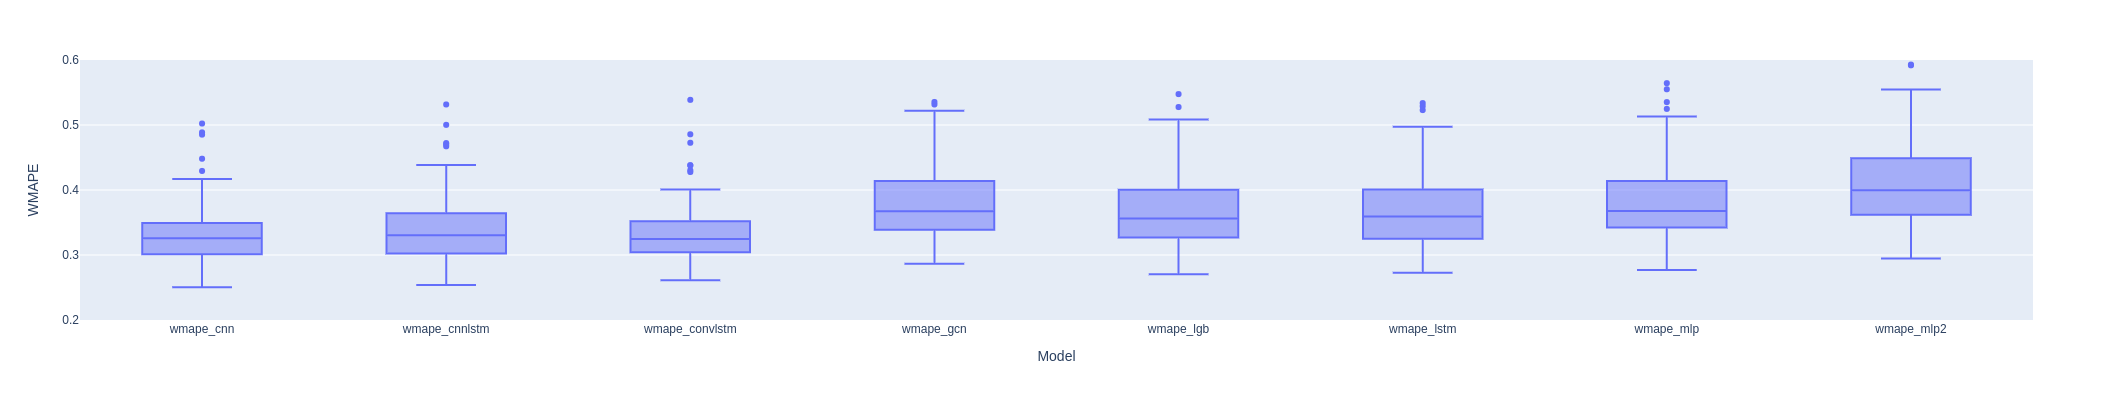

In [122]:
# fig = px.box(metrics_melted,
fig = px.box(a[a["metric"].isin(["wmape_" + m for m in models if not m.startswith("p")])], 
             # x="month", y="value", color="metric", 
             x="metric", y="value", # color="metric", 
             labels=dict(month="Month", value="WMAPE", metric="Model"))
fig.update_xaxes(tickmode="linear")
# fig.update_layout(title={'text': "MLP errors vs month for capacity clusters of power plants",'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'})
fig.update_layout(yaxis_range=[0.2,0.60], autosize=False, width=1200, height=400)
fig.show()

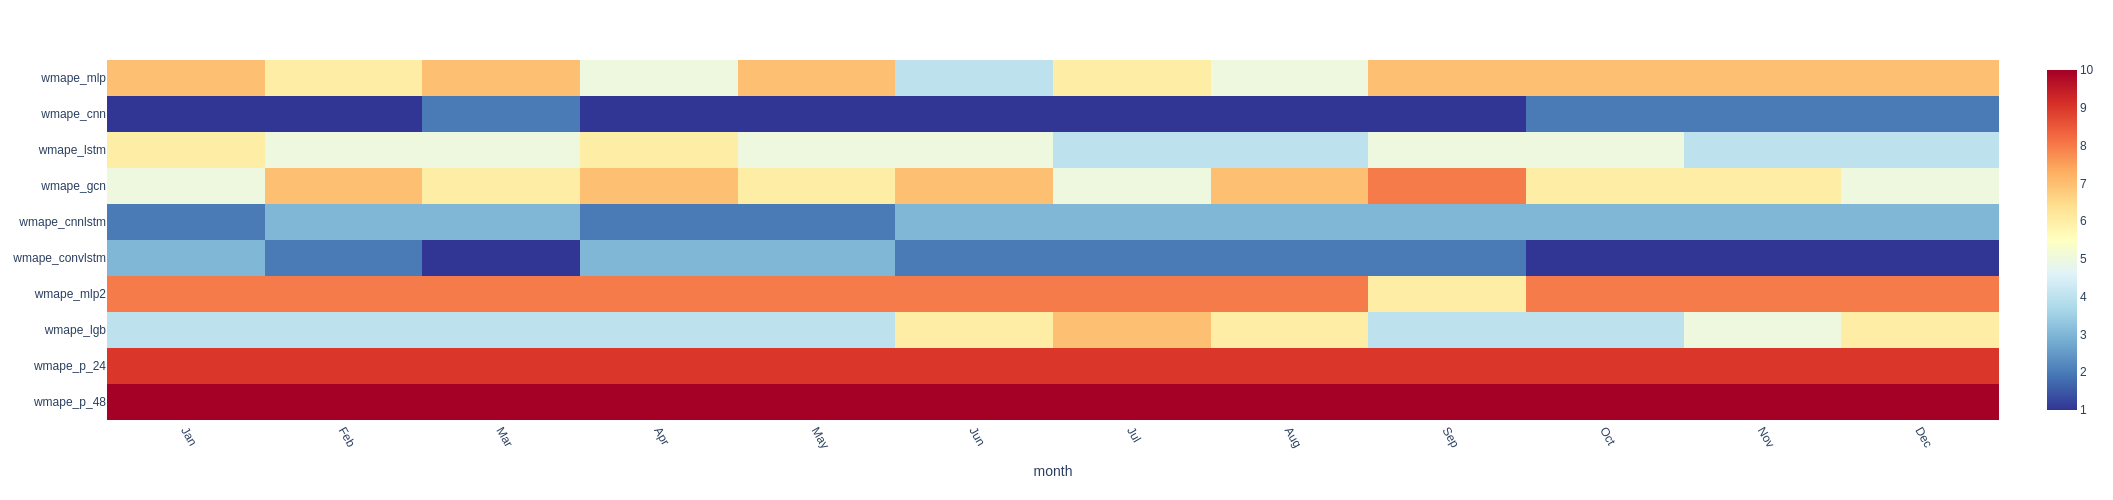

In [100]:
fig = px.imshow(metrics.groupby("month").mean().rank(1, ascending=True, method='first').T,
                # labels=dict(x="Month", y="Hour of Day", color="WMAPE"),
                # y=list(range(0,24)),
                x=['Jan', 'Feb', 'Mar', 'Apr', "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], 
                aspect="auto",
                # range_color=[0.2,.6],
                # color_continuous_scale=px.colors.diverging.balance,
                color_continuous_scale=COLORS
               )
fig.update_xaxes(side="bottom", tickangle=60, tickmode="linear")
fig.update_yaxes(tickmode="linear")
fig.update_layout(autosize=False, width=500, height=500)
fig.show()


In [73]:
metrics_melted

rt_plant_id month      metric     value category
0              672   Jan   wmape_mlp  0.309452     High
1              672   Feb   wmape_mlp  0.359602     High
2              672   Mar   wmape_mlp  0.356620     High
3              672   Apr   wmape_mlp  0.484576     High
4              672   May   wmape_mlp  0.501769     High
...            ...   ...         ...       ...      ...
10795         2374   Aug  wmape_p_48  0.685299      Low
10796         2374   Sep  wmape_p_48  0.949787      Low
10797         2374   Oct  wmape_p_48  1.085717      Low
10798         2374   Nov  wmape_p_48  1.137678      Low
10799         2374   Dec  wmape_p_48  0.893460      Low

[10800 rows x 5 columns]

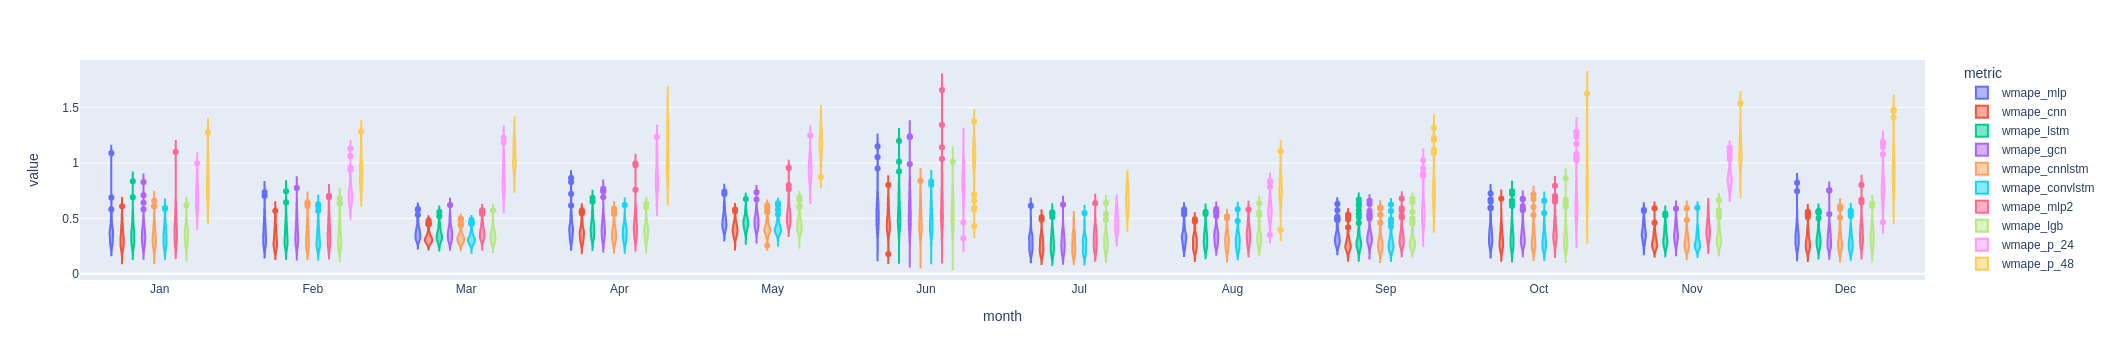

In [123]:
fig = px.violin(metrics_melted, x="month", y="value", color="metric")
fig.show()

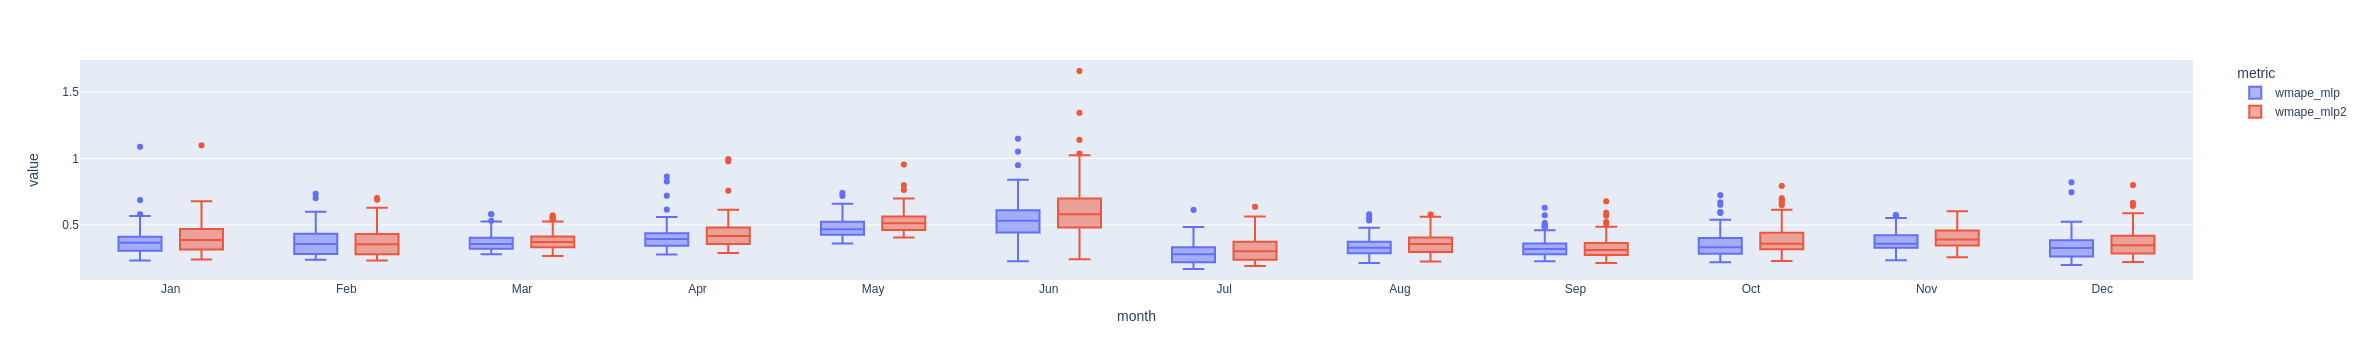

In [75]:
fig = px.box(metrics_melted[metrics_melted["metric"].isin(["wmape_mlp", "wmape_mlp2"])], x="month", y="value", color="metric")
fig.show()

In [ ]:
metrics

In [ ]:
rankings

In [ ]:
metrics[metrics.index.isin([1513], level=0)]

# Predictions

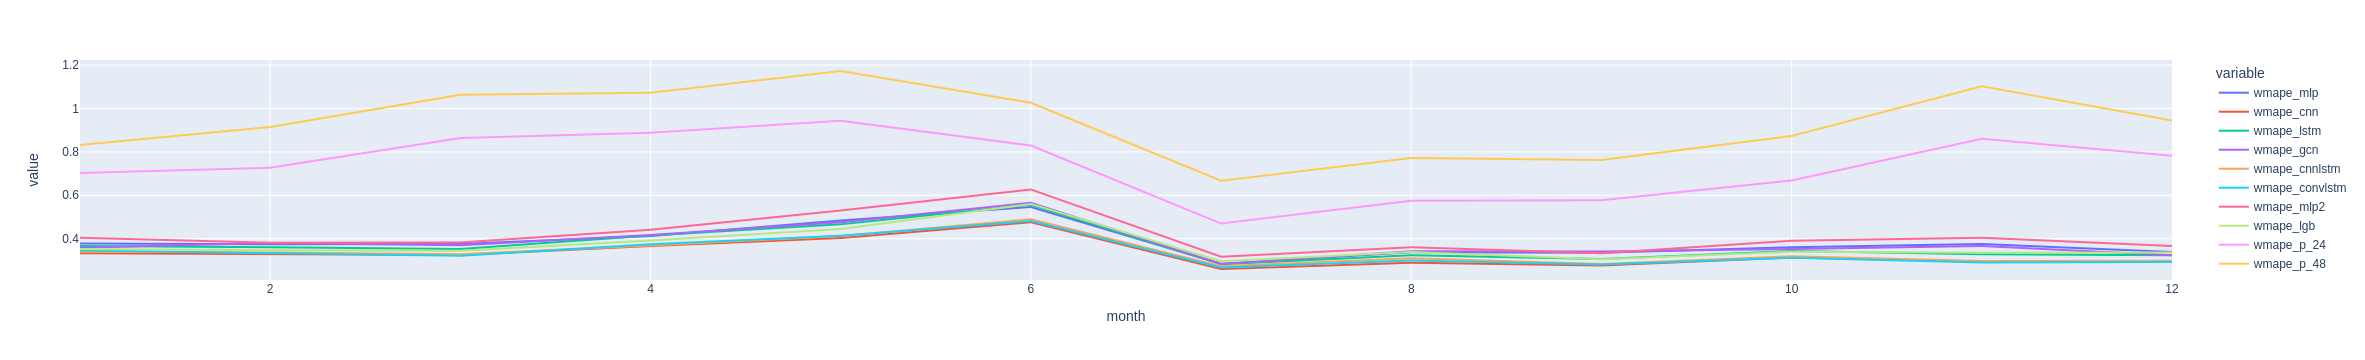

In [76]:
fig = px.line(pd.melt(metrics.groupby(metrics.index.get_level_values(1)).mean(), ignore_index=False).reset_index(), x="month", y="value", color="variable")
fig.show()
# metrics.groupby("month").mean().plot()

In [ ]:
# fig = px.histogram(rankings_melted, x="month", y="value", color="rank")
# fig.show()

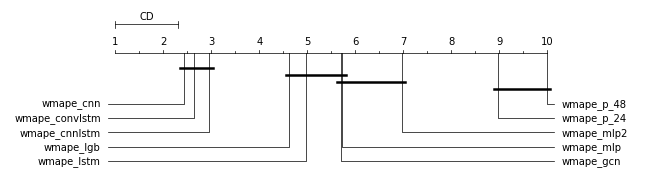

In [97]:
import Orange
import matplotlib.pyplot as plt
df = rankings.groupby("rt_plant_id").mean()
names = df.mean().index
avranks = df.mean().values

cd = Orange.evaluation.compute_CD(avranks, len(df), alpha="0.1")
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
# plt.show()
plt.savefig("nemenyi.png")

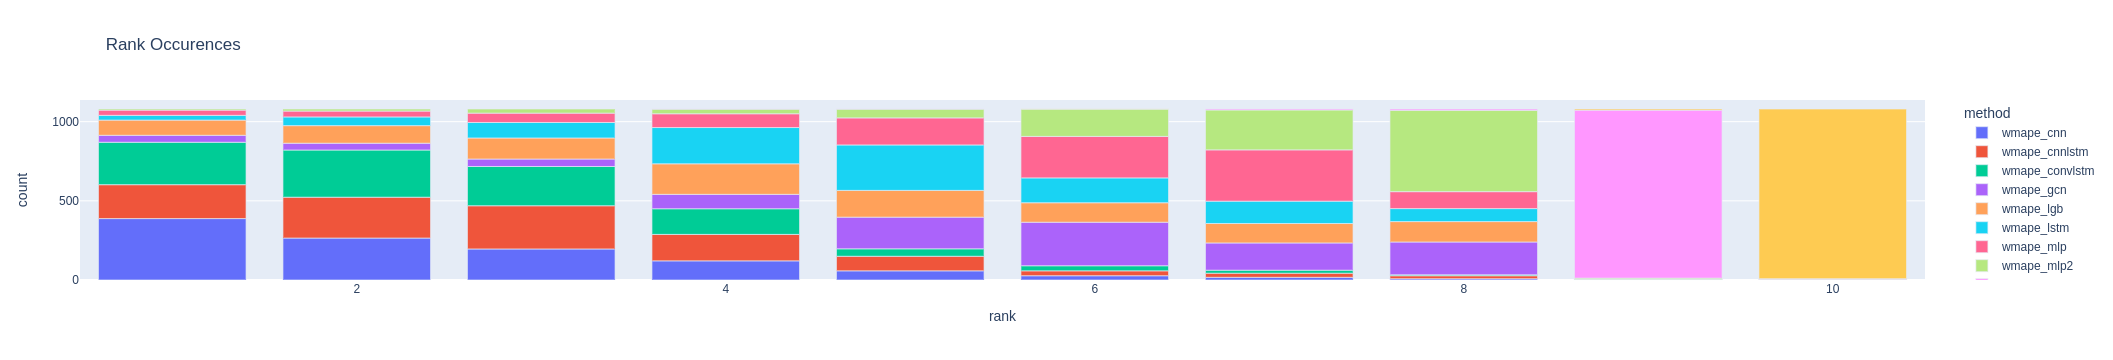

In [98]:
metrics_ = metrics
metrics_ordered = pd.concat([ 
    metrics_.T.apply(lambda x: x.nsmallest(i+1).idxmax())
    for i in range(metrics.shape[1])
], axis=1)
metrics_ordered.columns = [i+1 for i in range(metrics.shape[1])]
metrics_ordered = pd.melt(metrics_ordered, var_name="rank", value_name="method").value_counts().reset_index().rename(columns={0: "count"})
fig = px.bar(metrics_ordered.sort_values(["rank", "method"]), x="rank", y="count", color="method", title="Rank Occurences")
fig.show()

In [99]:
metrics_ordered

rank      method  count
0     10  wmape_p_48   1072
1      9  wmape_p_24   1061
2      8  wmape_mlp2    514
3      1   wmape_cnn    388
4      7   wmape_mlp    324
..   ...         ...    ...
74     9  wmape_lstm      1
75    10   wmape_lgb      1
76     9   wmape_gcn      1
77     4  wmape_p_24      1
78     5  wmape_p_24      1

[79 rows x 3 columns]

In [ ]:
wandb.finish()